In [35]:
import jax
jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
#import keql_tools
#reload(keql_tools)
#from keql_tools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from GP_sampler import *
from plotting import *
from evaluation_metrics import *

import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize

from LM_Solve import adaptive_refine_solution

## Utils

In [36]:
## Utils
# Build interior and boundary grids
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [37]:
def get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, vmapped_rhs, seed):
    """
        Gets samples(functions) of GP. 

        Args:
            num_obs (list): List of integers of number of observed points per function.
            xy_int (jnp.array): Interior domain to get the sample.
            xy_bdy (jnp.array): Boundary domain.
            vmapped_u_true_functions (list): List of vmapped u true functions.
            vmapped_u_true_functions (list): List of vmapped f true functions.
            seed (int): Integer to fix the simulation.

        Returns:
            list: List of lists xy_obs, u_obs, f_obs.   
    """

    if len(num_obs) != len(vmapped_u_true_functions):
        raise Exception("len of list of provided observed points not same as len of list of provided functions.")
    
    num_f = len(vmapped_rhs)
    key = jax.random.PRNGKey(seed)
    seed = jax.random.randint(key=key, shape=(num_f,), minval=1, maxval=40)
    xy_obs, u_obs, f_obs =  [], [], []
    for i, num_ob in enumerate(num_obs):
        np.random.seed(seed[i])
        xy_sample_indsi = np.random.choice(list(np.arange(len(xy_int))),num_ob,replace = False)
        xy_obsi = jnp.vstack([xy_bdy,xy_int[xy_sample_indsi]])
        xy_obs.append(xy_obsi)
        u_obs.append(vmapped_u_true_functions[i](xy_obsi))
        f_obs.append(rhs_functions[i](xy_obsi))
    return xy_obs, u_obs, f_obs

In [38]:
# Build operator features
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

In [39]:
def run_exp(m, run):
    # Define grid to get samples from GP
    x_grid=jnp.linspace(0,1,25)
    y_grid=jnp.linspace(0,1,25)
    X,Y=jnp.meshgrid(x_grid,y_grid)
    pairs = jnp.vstack([X.ravel(), Y.ravel()]).T

    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = run
                                        )  
                                        )

    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for any u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 8
    # Ghost grid - Same per function
    xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
    xy_all = jnp.vstack([xy_bdy,xy_int])

    # Number of observed points per u
    num_obs = [2]*m

    xy_obs, u_obs, f_obs = get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, rhs_functions, seed=2024)

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_models = tuple([InducedRKHS(
        xy_all,
        feature_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = (xy_int,)*m

    rhs_values = tuple(rhs_func(xy_int) for rhs_func in rhs_functions)

    all_u_params_init = tuple([model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for model,model_params in zip(u_models,all_u_params_init) ])


    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
    

    class P_model():

        kernel_function = jit(
            get_kernel_block_ops(k_P,[eval_k],[eval_k])
        )

        num_params = len(grid_features_u_init)

        @jit
        def predict(input_data,params):
            K = P_model.kernel_function(input_data,input_data)
            return K@params
        
        def get_P_eval(input_data,params):
            def predict(prediction_points):
                K = P_model.kernel_function(prediction_points,input_data)
                return K@params
            return predict
        
    collocation_points = tuple([xy_int]*m)
    
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_int))])

    params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 501,
        init_alpha=3,
        line_search_increase_ratio=2.
    )

    p_adjusted,refinement_losses,reg_sequence = adaptive_refine_solution(params,EqnModel,1e-1,500)

    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # Estimated P from 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    
    S_train = model_grid_features_all
    P_func = P_model.get_P_eval(S_train,P_sol)

    # Estimated P from 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
    S_train_2 = init_P_features 
    K = P_model.kernel_function(S_train_2,S_train_2)
    P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)
    P_func2 = P_model.get_P_eval(S_train_2,P_params_naive)

    # P[\phi(w)](fine_grid)
    def evaluate_hatP(P_func, w, fine_grid, feature_operators):

        # Build S_test
        w_features = jnp.array([jax.vmap(operator(w,0))(xy_fine_int) for operator in feature_operators]).T
        model_fine_features = jnp.hstack([fine_grid, w_features])
        S_test = model_fine_features


        #P_preds_model_features = P_model.kernel_function(S_test,S_train)@P_sol 
        P_preds = P_func(S_test)
        return P_preds
    
    # In sample errors

    # Get list of approximated functions ^U = [^u_1, ^u_2, ^u_3]
    true = [f(xy_fine_int) for f in rhs_functions]

    u_approx_funcs = [u_models[ind].get_eval_function(u_sols[ind]) 
                    for ind in range(m)]
    pred1_5 = [
        evaluate_hatP(
        P_func,
        u, xy_fine_int,feature_operators) for u in u_approx_funcs
    ]

    twostep_u_approx_funcs = [u_models[ind].get_eval_function(all_u_params_init[ind]) 
                    for ind in range(m)]
    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in twostep_u_approx_funcs
    ]
    in_sample_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)])) # RMSE
    in_sample_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))
    

    # Out of sample
    M = 50
    kernel_GP = get_gaussianRBF(0.2)
    # Sample M test functions from GP(0,K)
    w_test_functions = GP_sampler(num_samples = M,
                    X = pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    vmapped_w_test_functions = tuple([jax.vmap(w) for w in w_test_functions]) # vmap'ed
    w_rhs_functions = tuple([jax.vmap(get_rhs_darcy(w)) for w in w_test_functions]) #vmap'ed

    # mean 
    true = [f_w(xy_fine_int) for f_w in w_rhs_functions]
    #pred = [evaluate_hatP(w, xy_fine_int, u_sols, P_sol,feature_operators) for w in w_test_functions]
    pred1_5 = [
        evaluate_hatP(
        lambda x:P_model.kernel_function(x,S_train)@P_sol,
        w, xy_fine_int,feature_operators) for w in w_test_functions
    ]

    pred2 = [
        evaluate_hatP(
        P_func2,
        u, xy_fine_int,feature_operators) for u in w_test_functions
    ]

    out_sample_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    in_sample_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return in_sample_1_5, in_sample_2, out_sample_1_5, out_sample_2

## Run big for loop

In [40]:
errors_P_dic = {'in_sample_1_5' : [], 'in_sample_2' : [],'out_sample_1_5' : [], 'out_sample_2' : []}
for m in [2**i for i in range(5)]:
    in_sample_1_5 = []
    in_sample_2 = []
    out_sample_1_5 = []
    out_sample_2 = []
    for run in range(10):
        res = run_exp(m, run)
        in_sample_1_5.append(res[0])
        in_sample_2.append(res[1])
        out_sample_1_5.append(res[2])
        out_sample_2.append(res[3])
    print('Success with m = {} .'.format(m))
    errors_P_dic["in_sample_1_5"].append(in_sample_1_5)
    errors_P_dic["in_sample_2"].append(in_sample_2)
    errors_P_dic["out_sample_1_5"].append(out_sample_1_5)
    errors_P_dic["out_sample_2"].append(out_sample_2)

 15%|█▍        | 74/501 [00:00<00:01, 368.14it/s]

Iteration 0, loss = 195.3, Jres = 300.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 102.7, Jres = 7.117e+03, alpha = 2.5, improvement_ratio = 0.488
Iteration 2, loss = 3.307, Jres = 1.311e+04, alpha = 2.083, improvement_ratio = 0.9856
Iteration 3, loss = 1.233, Jres = 1.205e+03, alpha = 1.736, improvement_ratio = 1.004
Iteration 4, loss = 0.8931, Jres = 93.3, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 0.6665, Jres = 48.28, alpha = 1.206, improvement_ratio = 1.005
Iteration 50, loss = 0.0006679, Jres = 3.898, alpha = 0.0006836, improvement_ratio = 0.7337


 30%|██▉       | 150/501 [00:00<00:00, 373.98it/s]

Iteration 100, loss = 1.131e-05, Jres = 0.3413, alpha = 3.081e-05, improvement_ratio = 0.8082
Iteration 150, loss = 3.024e-06, Jres = 0.07484, alpha = 4.976e-06, improvement_ratio = 0.8003


 53%|█████▎    | 264/501 [00:00<00:00, 375.23it/s]

Iteration 200, loss = 2.727e-06, Jres = 0.0364, alpha = 3.456e-06, improvement_ratio = 0.6869
Iteration 250, loss = 2.681e-06, Jres = 0.03182, alpha = 3.456e-06, improvement_ratio = 0.692


 68%|██████▊   | 340/501 [00:00<00:00, 374.01it/s]

Iteration 300, loss = 2.648e-06, Jres = 0.0281, alpha = 3.456e-06, improvement_ratio = 0.7008
Iteration 350, loss = 2.624e-06, Jres = 0.02511, alpha = 3.456e-06, improvement_ratio = 0.7076


 91%|█████████ | 454/501 [00:01<00:00, 372.89it/s]

Iteration 400, loss = 2.605e-06, Jres = 0.02252, alpha = 3.456e-06, improvement_ratio = 0.715
Iteration 450, loss = 2.591e-06, Jres = 0.02006, alpha = 3.456e-06, improvement_ratio = 0.7257


100%|██████████| 501/501 [00:01<00:00, 372.94it/s]


Iteration 500, loss = 2.58e-06, Jres = 0.01765, alpha = 3.456e-06, improvement_ratio = 0.7413


  7%|▋         | 35/501 [00:00<00:01, 343.33it/s]

Iteration 0, loss = 177.1, Jres = 171.0, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 154.3, Jres = 6.216e+03, alpha = 24.0, improvement_ratio = 0.1538
Iteration 2, loss = 22.63, Jres = 1.849e+04, alpha = 16.67, improvement_ratio = 0.962
Iteration 3, loss = 15.72, Jres = 2.096e+03, alpha = 13.89, improvement_ratio = 0.979
Iteration 4, loss = 13.57, Jres = 181.6, alpha = 11.57, improvement_ratio = 1.017
Iteration 5, loss = 12.06, Jres = 72.74, alpha = 9.645, improvement_ratio = 1.024
Iteration 50, loss = 0.005587, Jres = 2.451, alpha = 0.002637, improvement_ratio = 0.972


 28%|██▊       | 142/501 [00:00<00:01, 347.72it/s]

Iteration 100, loss = 1.935e-05, Jres = 0.4781, alpha = 1.6e-05, improvement_ratio = 0.779
Iteration 150, loss = 5.864e-06, Jres = 0.1385, alpha = 5.358e-06, improvement_ratio = 0.7874


 50%|████▉     | 250/501 [00:00<00:00, 351.38it/s]

Iteration 200, loss = 4.517e-06, Jres = 0.03909, alpha = 2.584e-06, improvement_ratio = 0.7885
Iteration 250, loss = 4.407e-06, Jres = 0.02926, alpha = 2.584e-06, improvement_ratio = 0.7831


 71%|███████▏  | 358/501 [00:01<00:00, 352.43it/s]

Iteration 300, loss = 4.334e-06, Jres = 0.02626, alpha = 2.584e-06, improvement_ratio = 0.7779
Iteration 350, loss = 4.266e-06, Jres = 0.02285, alpha = 2.584e-06, improvement_ratio = 0.7893


 93%|█████████▎| 466/501 [00:01<00:00, 352.08it/s]

Iteration 400, loss = 4.196e-06, Jres = 0.02706, alpha = 2.153e-06, improvement_ratio = 0.7428
Iteration 450, loss = 4.129e-06, Jres = 0.0314, alpha = 1.794e-06, improvement_ratio = 0.7385


100%|██████████| 501/501 [00:01<00:00, 350.90it/s]


Iteration 500, loss = 4.073e-06, Jres = 0.03764, alpha = 1.495e-06, improvement_ratio = 0.7028


 15%|█▍        | 73/501 [00:00<00:01, 361.22it/s]

Iteration 0, loss = 93.9, Jres = 223.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 53.55, Jres = 4.34e+03, alpha = 2.5, improvement_ratio = 0.4447
Iteration 2, loss = 2.032, Jres = 9.026e+03, alpha = 2.083, improvement_ratio = 0.9775
Iteration 3, loss = 0.6604, Jres = 899.9, alpha = 1.736, improvement_ratio = 0.9935
Iteration 4, loss = 0.4796, Jres = 65.7, alpha = 1.447, improvement_ratio = 1.002
Iteration 5, loss = 0.3835, Jres = 21.69, alpha = 1.206, improvement_ratio = 1.002
Iteration 50, loss = 0.0002543, Jres = 2.148, alpha = 0.0004747, improvement_ratio = 0.7871


 29%|██▉       | 146/501 [00:00<00:01, 354.62it/s]

Iteration 100, loss = 2.815e-06, Jres = 0.1042, alpha = 1.783e-05, improvement_ratio = 0.8106
Iteration 150, loss = 1.325e-06, Jres = 0.02483, alpha = 4.147e-06, improvement_ratio = 0.7415


 51%|█████     | 254/501 [00:00<00:00, 356.91it/s]

Iteration 200, loss = 1.273e-06, Jres = 0.01459, alpha = 4.147e-06, improvement_ratio = 0.779
Iteration 250, loss = 1.249e-06, Jres = 0.01491, alpha = 3.456e-06, improvement_ratio = 0.7277


 72%|███████▏  | 362/501 [00:01<00:00, 357.50it/s]

Iteration 300, loss = 1.233e-06, Jres = 0.01115, alpha = 3.456e-06, improvement_ratio = 0.7732
Iteration 350, loss = 1.223e-06, Jres = 0.01243, alpha = 2.88e-06, improvement_ratio = 0.7096


 94%|█████████▍| 470/501 [00:01<00:00, 356.94it/s]

Iteration 400, loss = 1.216e-06, Jres = 0.009488, alpha = 2.88e-06, improvement_ratio = 0.7543
Iteration 450, loss = 1.212e-06, Jres = 0.007316, alpha = 2.88e-06, improvement_ratio = 0.7946


100%|██████████| 501/501 [00:01<00:00, 356.62it/s]


Iteration 500, loss = 1.211e-06, Jres = 0.007879, alpha = 2.4e-06, improvement_ratio = 0.7466


 15%|█▍        | 73/501 [00:00<00:01, 361.73it/s]

Iteration 0, loss = 158.1, Jres = 187.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 111.8, Jres = 7.553e+03, alpha = 40.0, improvement_ratio = 0.352
Iteration 2, loss = 12.4, Jres = 2.11e+04, alpha = 16.67, improvement_ratio = 0.9779
Iteration 3, loss = 8.12, Jres = 1.963e+03, alpha = 13.89, improvement_ratio = 1.003
Iteration 4, loss = 5.752, Jres = 136.6, alpha = 11.57, improvement_ratio = 1.034
Iteration 5, loss = 3.922, Jres = 94.84, alpha = 9.645, improvement_ratio = 1.033
Iteration 50, loss = 0.006125, Jres = 4.959, alpha = 0.002637, improvement_ratio = 0.9601


 30%|██▉       | 148/501 [00:00<00:00, 362.13it/s]

Iteration 100, loss = 1.215e-05, Jres = 0.6682, alpha = 2.304e-05, improvement_ratio = 0.7368
Iteration 150, loss = 4.104e-06, Jres = 0.1444, alpha = 7.715e-06, improvement_ratio = 0.8014


 51%|█████▏    | 257/501 [00:00<00:00, 358.00it/s]

Iteration 200, loss = 3.06e-06, Jres = 0.08011, alpha = 5.358e-06, improvement_ratio = 0.7496
Iteration 250, loss = 2.875e-06, Jres = 0.04035, alpha = 4.465e-06, improvement_ratio = 0.7867


 73%|███████▎  | 365/501 [00:01<00:00, 357.54it/s]

Iteration 300, loss = 2.808e-06, Jres = 0.03931, alpha = 3.721e-06, improvement_ratio = 0.7814
Iteration 350, loss = 2.76e-06, Jres = 0.04209, alpha = 3.101e-06, improvement_ratio = 0.7504


 94%|█████████▍| 473/501 [00:01<00:00, 357.60it/s]

Iteration 400, loss = 2.725e-06, Jres = 0.04519, alpha = 2.584e-06, improvement_ratio = 0.7097
Iteration 450, loss = 2.7e-06, Jres = 0.03261, alpha = 2.584e-06, improvement_ratio = 0.7775


100%|██████████| 501/501 [00:01<00:00, 358.10it/s]


Iteration 500, loss = 2.683e-06, Jres = 0.03329, alpha = 2.153e-06, improvement_ratio = 0.7403


 14%|█▍        | 69/501 [00:00<00:01, 340.54it/s]

Iteration 0, loss = 365.2, Jres = 314.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 254.6, Jres = 1.195e+04, alpha = 20.0, improvement_ratio = 0.329
Iteration 2, loss = 9.252, Jres = 3.219e+04, alpha = 16.67, improvement_ratio = 0.9803
Iteration 3, loss = 3.964, Jres = 3.053e+03, alpha = 13.89, improvement_ratio = 0.987
Iteration 4, loss = 3.324, Jres = 186.4, alpha = 11.57, improvement_ratio = 0.9982
Iteration 5, loss = 2.92, Jres = 51.99, alpha = 9.645, improvement_ratio = 1.0
Iteration 50, loss = 0.003249, Jres = 1.691, alpha = 0.002637, improvement_ratio = 0.9913


 28%|██▊       | 141/501 [00:00<00:01, 349.99it/s]

Iteration 100, loss = 1.164e-05, Jres = 0.6703, alpha = 3.981e-05, improvement_ratio = 0.8102
Iteration 150, loss = 3.189e-06, Jres = 0.1077, alpha = 5.358e-06, improvement_ratio = 0.7509


 50%|████▉     | 249/501 [00:00<00:00, 355.10it/s]

Iteration 200, loss = 2.975e-06, Jres = 0.06106, alpha = 5.358e-06, improvement_ratio = 0.7379
Iteration 250, loss = 2.887e-06, Jres = 0.05382, alpha = 5.358e-06, improvement_ratio = 0.7384


 71%|███████▏  | 357/501 [00:01<00:00, 356.36it/s]

Iteration 300, loss = 2.821e-06, Jres = 0.04844, alpha = 5.358e-06, improvement_ratio = 0.7412
Iteration 350, loss = 2.768e-06, Jres = 0.04388, alpha = 5.358e-06, improvement_ratio = 0.7444


 93%|█████████▎| 465/501 [00:01<00:00, 356.68it/s]

Iteration 400, loss = 2.726e-06, Jres = 0.03967, alpha = 5.358e-06, improvement_ratio = 0.7495
Iteration 450, loss = 2.691e-06, Jres = 0.03564, alpha = 5.358e-06, improvement_ratio = 0.7572


100%|██████████| 501/501 [00:01<00:00, 353.87it/s]


Iteration 500, loss = 2.663e-06, Jres = 0.03175, alpha = 5.358e-06, improvement_ratio = 0.7679


  7%|▋         | 35/501 [00:00<00:01, 343.71it/s]

Iteration 0, loss = 250.4, Jres = 241.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 184.4, Jres = 8.73e+03, alpha = 20.0, improvement_ratio = 0.2828
Iteration 2, loss = 11.01, Jres = 2.27e+04, alpha = 16.67, improvement_ratio = 0.9793
Iteration 3, loss = 6.496, Jres = 2.211e+03, alpha = 13.89, improvement_ratio = 0.9948
Iteration 4, loss = 5.721, Jres = 135.4, alpha = 11.57, improvement_ratio = 1.014
Iteration 5, loss = 5.126, Jres = 48.98, alpha = 9.645, improvement_ratio = 1.015
Iteration 50, loss = 0.007757, Jres = 10.9, alpha = 0.002637, improvement_ratio = 0.89


 29%|██▉       | 147/501 [00:00<00:00, 360.60it/s]

Iteration 100, loss = 0.0001281, Jres = 1.5, alpha = 8.255e-05, improvement_ratio = 0.7884
Iteration 150, loss = 6.006e-06, Jres = 0.2012, alpha = 5.358e-06, improvement_ratio = 0.765


 51%|█████▏    | 257/501 [00:00<00:00, 356.26it/s]

Iteration 200, loss = 5.14e-06, Jres = 0.0835, alpha = 1.794e-06, improvement_ratio = 0.7122
Iteration 250, loss = 5.021e-06, Jres = 0.07923, alpha = 1.794e-06, improvement_ratio = 0.6732


 73%|███████▎  | 365/501 [00:01<00:00, 353.41it/s]

Iteration 300, loss = 4.914e-06, Jres = 0.08665, alpha = 1.794e-06, improvement_ratio = 0.6005
Iteration 350, loss = 4.787e-06, Jres = 0.0798, alpha = 1.794e-06, improvement_ratio = 0.6765


 87%|████████▋ | 437/501 [00:01<00:00, 352.59it/s]

Iteration 400, loss = 4.645e-06, Jres = 0.05008, alpha = 1.794e-06, improvement_ratio = 0.7064
Iteration 450, loss = 4.517e-06, Jres = 0.02822, alpha = 1.794e-06, improvement_ratio = 0.6483


100%|██████████| 501/501 [00:01<00:00, 354.48it/s]


Iteration 500, loss = 4.417e-06, Jres = 0.01715, alpha = 1.794e-06, improvement_ratio = 0.658


 14%|█▎        | 68/501 [00:00<00:01, 337.79it/s]

Iteration 0, loss = 301.1, Jres = 240.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 259.1, Jres = 9.278e+03, alpha = 48.0, improvement_ratio = 0.177
Iteration 2, loss = 16.33, Jres = 3.398e+04, alpha = 16.67, improvement_ratio = 0.9705
Iteration 3, loss = 5.2, Jres = 3.964e+03, alpha = 13.89, improvement_ratio = 0.9953
Iteration 4, loss = 3.818, Jres = 337.2, alpha = 11.57, improvement_ratio = 1.011
Iteration 5, loss = 3.165, Jres = 64.03, alpha = 9.645, improvement_ratio = 1.011
Iteration 50, loss = 0.003872, Jres = 2.936, alpha = 0.002637, improvement_ratio = 0.9623


 27%|██▋       | 137/501 [00:00<00:01, 338.61it/s]

Iteration 100, loss = 2.731e-05, Jres = 1.179, alpha = 5.732e-05, improvement_ratio = 0.7822
Iteration 150, loss = 3.64e-06, Jres = 0.1516, alpha = 4.465e-06, improvement_ratio = 0.7346


 48%|████▊     | 240/501 [00:00<00:00, 337.84it/s]

Iteration 200, loss = 3.356e-06, Jres = 0.06266, alpha = 4.465e-06, improvement_ratio = 0.6802
Iteration 250, loss = 3.284e-06, Jres = 0.0486, alpha = 4.465e-06, improvement_ratio = 0.7034


 69%|██████▊   | 344/501 [00:01<00:00, 339.42it/s]

Iteration 300, loss = 3.239e-06, Jres = 0.04081, alpha = 4.465e-06, improvement_ratio = 0.7257
Iteration 350, loss = 3.206e-06, Jres = 0.03578, alpha = 4.465e-06, improvement_ratio = 0.7392


 89%|████████▉ | 448/501 [00:01<00:00, 339.27it/s]

Iteration 400, loss = 3.181e-06, Jres = 0.03197, alpha = 4.465e-06, improvement_ratio = 0.748
Iteration 450, loss = 3.161e-06, Jres = 0.02877, alpha = 4.465e-06, improvement_ratio = 0.7553


100%|██████████| 501/501 [00:01<00:00, 337.70it/s]


Iteration 500, loss = 3.146e-06, Jres = 0.02596, alpha = 4.465e-06, improvement_ratio = 0.7628


  7%|▋         | 36/501 [00:00<00:01, 350.38it/s]

Iteration 0, loss = 208.4, Jres = 294.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 107.4, Jres = 8.421e+03, alpha = 2.5, improvement_ratio = 0.4995
Iteration 2, loss = 5.514, Jres = 1.472e+04, alpha = 2.083, improvement_ratio = 0.9738
Iteration 3, loss = 2.137, Jres = 1.641e+03, alpha = 1.736, improvement_ratio = 0.9987
Iteration 4, loss = 1.565, Jres = 141.4, alpha = 1.447, improvement_ratio = 1.015
Iteration 5, loss = 1.171, Jres = 23.97, alpha = 1.206, improvement_ratio = 1.008
Iteration 50, loss = 0.001565, Jres = 8.696, alpha = 0.0008203, improvement_ratio = 0.7242


 29%|██▊       | 144/501 [00:00<00:01, 351.66it/s]

Iteration 100, loss = 1.053e-05, Jres = 0.5637, alpha = 2.568e-05, improvement_ratio = 0.7853
Iteration 150, loss = 4.763e-06, Jres = 0.07636, alpha = 5.971e-06, improvement_ratio = 0.7975


 50%|████▉     | 249/501 [00:00<00:00, 329.57it/s]

Iteration 200, loss = 4.051e-06, Jres = 0.03087, alpha = 1.157e-06, improvement_ratio = 0.7892
Iteration 250, loss = 3.994e-06, Jres = 0.0123, alpha = 1e-06, improvement_ratio = 0.6658


 69%|██████▉   | 348/501 [00:01<00:00, 323.86it/s]

Iteration 300, loss = 3.987e-06, Jres = 0.005897, alpha = 1e-06, improvement_ratio = 0.6392
Iteration 350, loss = 3.988e-06, Jres = 0.004949, alpha = 1e-06, improvement_ratio = 0.6647


 91%|█████████ | 455/501 [00:01<00:00, 344.38it/s]

Iteration 400, loss = 3.993e-06, Jres = 0.004898, alpha = 1e-06, improvement_ratio = 0.6894
Iteration 450, loss = 3.997e-06, Jres = 0.005233, alpha = 1e-06, improvement_ratio = 0.6904


100%|██████████| 501/501 [00:01<00:00, 338.77it/s]


Iteration 500, loss = 4.001e-06, Jres = 0.006367, alpha = 1e-06, improvement_ratio = 0.6574


 14%|█▍        | 72/501 [00:00<00:01, 358.27it/s]

Iteration 0, loss = 201.9, Jres = 285.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 171.8, Jres = 5.682e+03, alpha = 3.0, improvement_ratio = 0.1617
Iteration 2, loss = 11.81, Jres = 1.508e+04, alpha = 2.5, improvement_ratio = 0.965
Iteration 3, loss = 4.515, Jres = 1.864e+03, alpha = 2.083, improvement_ratio = 0.992
Iteration 4, loss = 3.065, Jres = 209.1, alpha = 1.736, improvement_ratio = 1.028
Iteration 5, loss = 2.345, Jres = 47.35, alpha = 1.447, improvement_ratio = 1.015
Iteration 50, loss = 0.000821, Jres = 5.113, alpha = 0.0005696, improvement_ratio = 0.7762


 29%|██▉       | 146/501 [00:00<00:00, 362.55it/s]

Iteration 100, loss = 5.972e-06, Jres = 0.1923, alpha = 8.599e-06, improvement_ratio = 0.7608
Iteration 150, loss = 3.713e-06, Jres = 0.05683, alpha = 2.4e-06, improvement_ratio = 0.7415


 51%|█████▏    | 257/501 [00:00<00:00, 363.38it/s]

Iteration 200, loss = 3.482e-06, Jres = 0.02463, alpha = 2.4e-06, improvement_ratio = 0.7475
Iteration 250, loss = 3.432e-06, Jres = 0.01461, alpha = 2.4e-06, improvement_ratio = 0.7924


 73%|███████▎  | 368/501 [00:01<00:00, 363.47it/s]

Iteration 300, loss = 3.409e-06, Jres = 0.01319, alpha = 2e-06, improvement_ratio = 0.763
Iteration 350, loss = 3.398e-06, Jres = 0.01209, alpha = 1.666e-06, improvement_ratio = 0.7324


 88%|████████▊ | 442/501 [00:01<00:00, 363.85it/s]

Iteration 400, loss = 3.394e-06, Jres = 0.007565, alpha = 1.666e-06, improvement_ratio = 0.8
Iteration 450, loss = 3.395e-06, Jres = 0.006559, alpha = 1.389e-06, improvement_ratio = 0.7721


100%|██████████| 501/501 [00:01<00:00, 363.05it/s]


Iteration 500, loss = 3.399e-06, Jres = 0.00588, alpha = 1.157e-06, improvement_ratio = 0.725


 13%|█▎        | 66/501 [00:00<00:01, 328.97it/s]

Iteration 0, loss = 191.5, Jres = 211.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 163.3, Jres = 6.846e+03, alpha = 24.0, improvement_ratio = 0.1581
Iteration 2, loss = 8.048, Jres = 2.36e+04, alpha = 16.67, improvement_ratio = 0.9811
Iteration 3, loss = 4.459, Jres = 2.417e+03, alpha = 13.89, improvement_ratio = 0.9951
Iteration 4, loss = 3.98, Jres = 145.2, alpha = 11.57, improvement_ratio = 1.012
Iteration 5, loss = 3.612, Jres = 42.38, alpha = 9.645, improvement_ratio = 1.015
Iteration 50, loss = 0.00824, Jres = 9.57, alpha = 0.003165, improvement_ratio = 0.923


 28%|██▊       | 140/501 [00:00<00:01, 350.57it/s]

Iteration 100, loss = 3.333e-05, Jres = 1.055, alpha = 3.981e-05, improvement_ratio = 0.6908
Iteration 150, loss = 3.695e-06, Jres = 0.03068, alpha = 2.153e-06, improvement_ratio = 0.6887


 50%|█████     | 251/501 [00:00<00:00, 359.57it/s]

Iteration 200, loss = 3.653e-06, Jres = 0.02461, alpha = 2.153e-06, improvement_ratio = 0.6338
Iteration 250, loss = 3.62e-06, Jres = 0.02177, alpha = 2.153e-06, improvement_ratio = 0.603


 72%|███████▏  | 362/501 [00:01<00:00, 361.08it/s]

Iteration 300, loss = 3.589e-06, Jres = 0.0196, alpha = 2.153e-06, improvement_ratio = 0.6082
Iteration 350, loss = 3.557e-06, Jres = 0.01934, alpha = 2.153e-06, improvement_ratio = 0.6336


 94%|█████████▍| 473/501 [00:01<00:00, 361.77it/s]

Iteration 400, loss = 3.523e-06, Jres = 0.01971, alpha = 2.153e-06, improvement_ratio = 0.6783
Iteration 450, loss = 3.492e-06, Jres = 0.01927, alpha = 2.153e-06, improvement_ratio = 0.7317


100%|██████████| 501/501 [00:01<00:00, 356.59it/s]


Iteration 500, loss = 3.465e-06, Jres = 0.01785, alpha = 2.153e-06, improvement_ratio = 0.7811


100%|██████████| 500/500 [00:14<00:00, 35.27it/s]


Success with m = 1 .


  8%|▊         | 40/501 [00:00<00:02, 199.13it/s]

Iteration 0, loss = 480.3, Jres = 495.3, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 244.3, Jres = 6.282e+03, alpha = 2.5, improvement_ratio = 0.528
Iteration 2, loss = 10.15, Jres = 1.241e+04, alpha = 2.083, improvement_ratio = 0.9864
Iteration 3, loss = 4.886, Jres = 1.113e+03, alpha = 1.736, improvement_ratio = 0.9965
Iteration 4, loss = 3.672, Jres = 53.13, alpha = 1.447, improvement_ratio = 0.9999
Iteration 5, loss = 2.822, Jres = 18.1, alpha = 1.206, improvement_ratio = 1.0


 16%|█▌        | 81/501 [00:00<00:02, 199.29it/s]

Iteration 50, loss = 0.002939, Jres = 6.483, alpha = 0.0004747, improvement_ratio = 0.7768


 24%|██▍       | 121/501 [00:00<00:01, 198.96it/s]

Iteration 100, loss = 2.058e-05, Jres = 0.2215, alpha = 1.486e-05, improvement_ratio = 0.7885


 36%|███▋      | 182/501 [00:00<00:01, 199.44it/s]

Iteration 150, loss = 1.294e-05, Jres = 0.07751, alpha = 4.147e-06, improvement_ratio = 0.7566


 45%|████▍     | 223/501 [00:01<00:01, 199.57it/s]

Iteration 200, loss = 1.136e-05, Jres = 0.0441, alpha = 2.88e-06, improvement_ratio = 0.7603


 56%|█████▋    | 283/501 [00:01<00:01, 199.31it/s]

Iteration 250, loss = 1.089e-05, Jres = 0.02478, alpha = 2.4e-06, improvement_ratio = 0.7953


 65%|██████▍   | 324/501 [00:01<00:00, 199.57it/s]

Iteration 300, loss = 1.074e-05, Jres = 0.02379, alpha = 1.666e-06, improvement_ratio = 0.7333


 77%|███████▋  | 385/501 [00:01<00:00, 199.58it/s]

Iteration 350, loss = 1.071e-05, Jres = 0.01661, alpha = 1.389e-06, improvement_ratio = 0.7653


 85%|████████▍ | 425/501 [00:02<00:00, 199.57it/s]

Iteration 400, loss = 1.074e-05, Jres = 0.01095, alpha = 1e-06, improvement_ratio = 0.6892


 97%|█████████▋| 485/501 [00:02<00:00, 198.53it/s]

Iteration 450, loss = 1.079e-05, Jres = 0.006118, alpha = 8.333e-07, improvement_ratio = 0.8628


100%|██████████| 501/501 [00:02<00:00, 199.16it/s]


Iteration 500, loss = 1.082e-05, Jres = 0.002753, alpha = 8.333e-07, improvement_ratio = 0.9327


  8%|▊         | 39/501 [00:00<00:02, 194.74it/s]

Iteration 0, loss = 375.3, Jres = 333.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 306.3, Jres = 6.053e+03, alpha = 10.0, improvement_ratio = 0.2125
Iteration 2, loss = 20.36, Jres = 1.974e+04, alpha = 8.333, improvement_ratio = 0.9758
Iteration 3, loss = 9.459, Jres = 1.975e+03, alpha = 6.944, improvement_ratio = 1.001
Iteration 4, loss = 6.972, Jres = 171.6, alpha = 5.787, improvement_ratio = 1.018
Iteration 5, loss = 5.687, Jres = 71.28, alpha = 4.823, improvement_ratio = 1.013


 16%|█▌        | 80/501 [00:00<00:02, 198.14it/s]

Iteration 50, loss = 0.01229, Jres = 13.58, alpha = 0.001319, improvement_ratio = 0.8181


 28%|██▊       | 140/501 [00:00<00:01, 199.33it/s]

Iteration 100, loss = 0.0001084, Jres = 1.489, alpha = 7.132e-05, improvement_ratio = 0.7839


 36%|███▌      | 180/501 [00:00<00:01, 199.46it/s]

Iteration 150, loss = 1.629e-05, Jres = 0.3314, alpha = 1.152e-05, improvement_ratio = 0.6745


 48%|████▊     | 240/501 [00:01<00:01, 199.60it/s]

Iteration 200, loss = 1.04e-05, Jres = 0.1179, alpha = 4.629e-06, improvement_ratio = 0.7322


 56%|█████▌    | 280/501 [00:01<00:01, 199.58it/s]

Iteration 250, loss = 9.689e-06, Jres = 0.04447, alpha = 2.679e-06, improvement_ratio = 0.7903


 68%|██████▊   | 341/501 [00:01<00:00, 201.35it/s]

Iteration 300, loss = 9.52e-06, Jres = 0.02999, alpha = 1.55e-06, improvement_ratio = 0.7316


 76%|███████▋  | 383/501 [00:01<00:00, 200.71it/s]

Iteration 350, loss = 9.492e-06, Jres = 0.01597, alpha = 1.077e-06, improvement_ratio = 0.7924


 85%|████████▍ | 425/501 [00:02<00:00, 199.65it/s]

Iteration 400, loss = 9.503e-06, Jres = 0.004755, alpha = 8.333e-07, improvement_ratio = 0.9314


 97%|█████████▋| 485/501 [00:02<00:00, 199.61it/s]

Iteration 450, loss = 9.514e-06, Jres = 0.001584, alpha = 8.333e-07, improvement_ratio = 0.9767


100%|██████████| 501/501 [00:02<00:00, 199.34it/s]


Iteration 500, loss = 9.522e-06, Jres = 0.0007998, alpha = 8.333e-07, improvement_ratio = 0.9871


  4%|▍         | 21/501 [00:00<00:02, 200.37it/s]

Iteration 0, loss = 198.8, Jres = 375.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 84.02, Jres = 4.752e+03, alpha = 2.5, improvement_ratio = 0.6148
Iteration 2, loss = 4.675, Jres = 7.011e+03, alpha = 2.083, improvement_ratio = 0.9834
Iteration 3, loss = 2.24, Jres = 662.8, alpha = 1.736, improvement_ratio = 1.015
Iteration 4, loss = 1.668, Jres = 41.59, alpha = 1.447, improvement_ratio = 1.023
Iteration 5, loss = 1.324, Jres = 13.29, alpha = 1.206, improvement_ratio = 1.013


 17%|█▋        | 84/501 [00:00<00:02, 204.18it/s]

Iteration 50, loss = 0.001603, Jres = 5.439, alpha = 0.0004747, improvement_ratio = 0.8326


 25%|██▌       | 126/501 [00:00<00:01, 205.10it/s]

Iteration 100, loss = 2.527e-05, Jres = 0.6698, alpha = 2.568e-05, improvement_ratio = 0.8012


 38%|███▊      | 189/501 [00:00<00:01, 204.12it/s]

Iteration 150, loss = 7.076e-06, Jres = 0.1272, alpha = 5.971e-06, improvement_ratio = 0.7891


 46%|████▌     | 231/501 [00:01<00:01, 204.34it/s]

Iteration 200, loss = 5.615e-06, Jres = 0.07087, alpha = 2e-06, improvement_ratio = 0.7234


 54%|█████▍    | 273/501 [00:01<00:01, 204.10it/s]

Iteration 250, loss = 5.36e-06, Jres = 0.02876, alpha = 1.666e-06, improvement_ratio = 0.738


 67%|██████▋   | 336/501 [00:01<00:00, 203.76it/s]

Iteration 300, loss = 5.311e-06, Jres = 0.01754, alpha = 1.666e-06, improvement_ratio = 0.7807


 75%|███████▌  | 378/501 [00:01<00:00, 203.22it/s]

Iteration 350, loss = 5.293e-06, Jres = 0.01663, alpha = 1.389e-06, improvement_ratio = 0.7455


 88%|████████▊ | 441/501 [00:02<00:00, 203.60it/s]

Iteration 400, loss = 5.286e-06, Jres = 0.01589, alpha = 1.157e-06, improvement_ratio = 0.7198


 96%|█████████▋| 483/501 [00:02<00:00, 203.20it/s]

Iteration 450, loss = 5.285e-06, Jres = 0.01364, alpha = 1e-06, improvement_ratio = 0.7309


100%|██████████| 501/501 [00:02<00:00, 203.38it/s]


Iteration 500, loss = 5.289e-06, Jres = 0.008484, alpha = 8.333e-07, improvement_ratio = 0.8249


  4%|▍         | 21/501 [00:00<00:02, 205.48it/s]

Iteration 0, loss = 372.3, Jres = 385.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 237.4, Jres = 5.118e+03, alpha = 2.5, improvement_ratio = 0.403
Iteration 2, loss = 12.34, Jres = 1.212e+04, alpha = 2.083, improvement_ratio = 0.9805
Iteration 3, loss = 5.688, Jres = 1.218e+03, alpha = 1.736, improvement_ratio = 0.9959
Iteration 4, loss = 4.403, Jres = 76.23, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 3.485, Jres = 22.14, alpha = 1.206, improvement_ratio = 1.012


 17%|█▋        | 86/501 [00:00<00:01, 208.03it/s]

Iteration 50, loss = 0.004121, Jres = 9.146, alpha = 0.0006836, improvement_ratio = 0.8114


 26%|██▌       | 130/501 [00:00<00:01, 210.45it/s]

Iteration 100, loss = 4.776e-05, Jres = 0.9032, alpha = 2.568e-05, improvement_ratio = 0.7695


 35%|███▍      | 174/501 [00:00<00:01, 212.25it/s]

Iteration 150, loss = 1.169e-05, Jres = 0.1184, alpha = 4.976e-06, improvement_ratio = 0.8102


 48%|████▊     | 240/501 [00:01<00:01, 211.66it/s]

Iteration 200, loss = 1.027e-05, Jres = 0.04398, alpha = 2e-06, improvement_ratio = 0.7789


 57%|█████▋    | 284/501 [00:01<00:01, 210.97it/s]

Iteration 250, loss = 1.013e-05, Jres = 0.02963, alpha = 1.157e-06, improvement_ratio = 0.7367


 65%|██████▌   | 328/501 [00:01<00:00, 210.40it/s]

Iteration 300, loss = 1.014e-05, Jres = 0.02267, alpha = 1e-06, improvement_ratio = 0.7698


 74%|███████▍  | 372/501 [00:01<00:00, 209.35it/s]

Iteration 350, loss = 1.018e-05, Jres = 0.01302, alpha = 8.333e-07, improvement_ratio = 0.857


 87%|████████▋ | 436/501 [00:02<00:00, 208.97it/s]

Iteration 400, loss = 1.022e-05, Jres = 0.007228, alpha = 8.333e-07, improvement_ratio = 0.9186


 96%|█████████▌| 479/501 [00:02<00:00, 209.53it/s]

Iteration 450, loss = 1.026e-05, Jres = 0.004041, alpha = 8.333e-07, improvement_ratio = 0.9547


100%|██████████| 501/501 [00:02<00:00, 209.76it/s]


Iteration 500, loss = 1.029e-05, Jres = 0.002316, alpha = 8.333e-07, improvement_ratio = 0.9742


  9%|▉         | 45/501 [00:00<00:02, 222.06it/s]

Iteration 0, loss = 248.4, Jres = 356.1, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 182.4, Jres = 5.006e+03, alpha = 2.5, improvement_ratio = 0.2912
Iteration 2, loss = 7.924, Jres = 1.288e+04, alpha = 2.083, improvement_ratio = 0.9794
Iteration 3, loss = 2.621, Jres = 1.283e+03, alpha = 1.736, improvement_ratio = 1.011
Iteration 4, loss = 1.915, Jres = 87.3, alpha = 1.447, improvement_ratio = 1.028
Iteration 5, loss = 1.534, Jres = 22.27, alpha = 1.206, improvement_ratio = 1.02


 18%|█▊        | 91/501 [00:00<00:01, 221.82it/s]

Iteration 50, loss = 0.003408, Jres = 9.66, alpha = 0.0006836, improvement_ratio = 0.8175


 27%|██▋       | 137/501 [00:00<00:01, 222.60it/s]

Iteration 100, loss = 6.094e-05, Jres = 1.181, alpha = 3.697e-05, improvement_ratio = 0.7752


 37%|███▋      | 183/501 [00:00<00:01, 222.28it/s]

Iteration 150, loss = 1.275e-05, Jres = 0.2715, alpha = 8.599e-06, improvement_ratio = 0.7962


 46%|████▌     | 229/501 [00:01<00:01, 221.46it/s]

Iteration 200, loss = 8.782e-06, Jres = 0.1314, alpha = 2.88e-06, improvement_ratio = 0.7727


 55%|█████▍    | 275/501 [00:01<00:01, 221.18it/s]

Iteration 250, loss = 8.253e-06, Jres = 0.05574, alpha = 1.666e-06, improvement_ratio = 0.7595


 69%|██████▊   | 344/501 [00:01<00:00, 221.14it/s]

Iteration 300, loss = 8.106e-06, Jres = 0.037, alpha = 1.157e-06, improvement_ratio = 0.7765


 78%|███████▊  | 390/501 [00:01<00:00, 220.96it/s]

Iteration 350, loss = 8.017e-06, Jres = 0.02474, alpha = 8.333e-07, improvement_ratio = 0.804


 87%|████████▋ | 436/501 [00:01<00:00, 220.98it/s]

Iteration 400, loss = 7.954e-06, Jres = 0.01533, alpha = 8.333e-07, improvement_ratio = 0.8517


 96%|█████████▌| 482/501 [00:02<00:00, 221.30it/s]

Iteration 450, loss = 7.909e-06, Jres = 0.01016, alpha = 8.333e-07, improvement_ratio = 0.8792


100%|██████████| 501/501 [00:02<00:00, 221.45it/s]


Iteration 500, loss = 7.876e-06, Jres = 0.007145, alpha = 8.333e-07, improvement_ratio = 0.897


  8%|▊         | 41/501 [00:00<00:02, 200.29it/s]

Iteration 0, loss = 217.1, Jres = 306.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 155.5, Jres = 5.018e+03, alpha = 2.5, improvement_ratio = 0.2981
Iteration 2, loss = 5.372, Jres = 1.248e+04, alpha = 2.083, improvement_ratio = 0.9782
Iteration 3, loss = 1.529, Jres = 1.296e+03, alpha = 1.736, improvement_ratio = 0.9984
Iteration 4, loss = 1.196, Jres = 65.85, alpha = 1.447, improvement_ratio = 1.011
Iteration 5, loss = 1.011, Jres = 9.575, alpha = 1.206, improvement_ratio = 1.006


 17%|█▋        | 83/501 [00:00<00:02, 199.36it/s]

Iteration 50, loss = 0.001676, Jres = 7.977, alpha = 0.0005696, improvement_ratio = 0.8576


 25%|██▍       | 123/501 [00:00<00:01, 199.59it/s]

Iteration 100, loss = 8.854e-06, Jres = 0.2896, alpha = 1.238e-05, improvement_ratio = 0.6956


 37%|███▋      | 183/501 [00:00<00:01, 199.67it/s]

Iteration 150, loss = 5.709e-06, Jres = 0.06727, alpha = 2.4e-06, improvement_ratio = 0.7411


 45%|████▍     | 223/501 [00:01<00:01, 199.63it/s]

Iteration 200, loss = 5.372e-06, Jres = 0.02685, alpha = 1.157e-06, improvement_ratio = 0.7437


 56%|█████▋    | 283/501 [00:01<00:01, 199.68it/s]

Iteration 250, loss = 5.356e-06, Jres = 0.008967, alpha = 8.333e-07, improvement_ratio = 0.8165


 65%|██████▍   | 324/501 [00:01<00:00, 199.70it/s]

Iteration 300, loss = 5.383e-06, Jres = 0.00465, alpha = 8.333e-07, improvement_ratio = 0.8804


 77%|███████▋  | 384/501 [00:01<00:00, 199.67it/s]

Iteration 350, loss = 5.409e-06, Jres = 0.002904, alpha = 8.333e-07, improvement_ratio = 0.9159


 85%|████████▍ | 424/501 [00:02<00:00, 199.67it/s]

Iteration 400, loss = 5.43e-06, Jres = 0.001952, alpha = 8.333e-07, improvement_ratio = 0.9394


 97%|█████████▋| 484/501 [00:02<00:00, 199.67it/s]

Iteration 450, loss = 5.448e-06, Jres = 0.001354, alpha = 8.333e-07, improvement_ratio = 0.9564


100%|██████████| 501/501 [00:02<00:00, 199.61it/s]


Iteration 500, loss = 5.463e-06, Jres = 0.0009534, alpha = 8.333e-07, improvement_ratio = 0.9688


  8%|▊         | 39/501 [00:00<00:02, 194.35it/s]

Iteration 0, loss = 192.5, Jres = 374.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 127.8, Jres = 4.998e+03, alpha = 10.0, improvement_ratio = 0.3994
Iteration 2, loss = 13.51, Jres = 1.214e+04, alpha = 8.333, improvement_ratio = 0.967
Iteration 3, loss = 6.951, Jres = 1.22e+03, alpha = 6.944, improvement_ratio = 1.003
Iteration 4, loss = 4.711, Jres = 124.5, alpha = 5.787, improvement_ratio = 1.027
Iteration 5, loss = 3.467, Jres = 62.62, alpha = 4.823, improvement_ratio = 1.025


 16%|█▌        | 80/501 [00:00<00:02, 198.16it/s]

Iteration 50, loss = 0.006622, Jres = 13.88, alpha = 0.001582, improvement_ratio = 0.7476


 28%|██▊       | 140/501 [00:00<00:01, 199.07it/s]

Iteration 100, loss = 0.0001354, Jres = 2.652, alpha = 0.0001027, improvement_ratio = 0.7516


 36%|███▌      | 180/501 [00:00<00:01, 199.37it/s]

Iteration 150, loss = 1.988e-05, Jres = 0.483, alpha = 1.99e-05, improvement_ratio = 0.6659


 48%|████▊     | 240/501 [00:01<00:01, 199.54it/s]

Iteration 200, loss = 1.038e-05, Jres = 0.2642, alpha = 7.999e-06, improvement_ratio = 0.7827


 56%|█████▌    | 280/501 [00:01<00:01, 199.57it/s]

Iteration 250, loss = 7.254e-06, Jres = 0.1658, alpha = 3.858e-06, improvement_ratio = 0.7293


 68%|██████▊   | 340/501 [00:01<00:00, 199.65it/s]

Iteration 300, loss = 6.435e-06, Jres = 0.07503, alpha = 2.679e-06, improvement_ratio = 0.7572


 76%|███████▌  | 380/501 [00:01<00:00, 199.54it/s]

Iteration 350, loss = 6.261e-06, Jres = 0.04037, alpha = 1.86e-06, improvement_ratio = 0.7811


 88%|████████▊ | 440/501 [00:02<00:00, 199.51it/s]

Iteration 400, loss = 6.226e-06, Jres = 0.0309, alpha = 1.292e-06, improvement_ratio = 0.796


 96%|█████████▌| 480/501 [00:02<00:00, 199.56it/s]

Iteration 450, loss = 6.228e-06, Jres = 0.01885, alpha = 8.333e-07, improvement_ratio = 0.8542


100%|██████████| 501/501 [00:02<00:00, 199.06it/s]


Iteration 500, loss = 6.243e-06, Jres = 0.008041, alpha = 8.333e-07, improvement_ratio = 0.9364


  8%|▊         | 42/501 [00:00<00:02, 209.05it/s]

Iteration 0, loss = 198.1, Jres = 322.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 131.8, Jres = 3.525e+03, alpha = 2.5, improvement_ratio = 0.37
Iteration 2, loss = 7.956, Jres = 8.462e+03, alpha = 2.083, improvement_ratio = 0.9817
Iteration 3, loss = 4.347, Jres = 821.2, alpha = 1.736, improvement_ratio = 1.002
Iteration 4, loss = 3.253, Jres = 50.98, alpha = 1.447, improvement_ratio = 1.03
Iteration 5, loss = 2.44, Jres = 25.6, alpha = 1.206, improvement_ratio = 1.032


 17%|█▋        | 85/501 [00:00<00:01, 208.80it/s]

Iteration 50, loss = 0.001111, Jres = 4.415, alpha = 0.0004747, improvement_ratio = 0.8199


 26%|██▌       | 128/501 [00:00<00:01, 209.51it/s]

Iteration 100, loss = 1.423e-05, Jres = 0.3403, alpha = 1.238e-05, improvement_ratio = 0.6815


 39%|███▊      | 193/501 [00:00<00:01, 209.15it/s]

Iteration 150, loss = 5.911e-06, Jres = 0.06746, alpha = 5.971e-06, improvement_ratio = 0.7817


 47%|████▋     | 235/501 [00:01<00:01, 209.41it/s]

Iteration 200, loss = 5.158e-06, Jres = 0.03004, alpha = 1.389e-06, improvement_ratio = 0.7782


 55%|█████▌    | 277/501 [00:01<00:01, 209.02it/s]

Iteration 250, loss = 5.096e-06, Jres = 0.01459, alpha = 8.333e-07, improvement_ratio = 0.8266


 68%|██████▊   | 340/501 [00:01<00:00, 208.22it/s]

Iteration 300, loss = 5.097e-06, Jres = 0.005237, alpha = 8.333e-07, improvement_ratio = 0.9339


 76%|███████▌  | 382/501 [00:01<00:00, 207.64it/s]

Iteration 350, loss = 5.102e-06, Jres = 0.0021, alpha = 8.333e-07, improvement_ratio = 0.9753


 85%|████████▍ | 424/501 [00:02<00:00, 207.76it/s]

Iteration 400, loss = 5.105e-06, Jres = 0.0009468, alpha = 8.333e-07, improvement_ratio = 0.9903


 97%|█████████▋| 487/501 [00:02<00:00, 206.77it/s]

Iteration 450, loss = 5.107e-06, Jres = 0.0004727, alpha = 8.333e-07, improvement_ratio = 0.9962


100%|██████████| 501/501 [00:02<00:00, 208.20it/s]


Iteration 500, loss = 5.109e-06, Jres = 0.0002548, alpha = 8.333e-07, improvement_ratio = 0.9987


  4%|▍         | 21/501 [00:00<00:02, 201.02it/s]

Iteration 0, loss = 138.4, Jres = 223.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 76.72, Jres = 2.516e+03, alpha = 2.5, improvement_ratio = 0.5023
Iteration 2, loss = 6.696, Jres = 5.262e+03, alpha = 2.083, improvement_ratio = 0.9805
Iteration 3, loss = 4.143, Jres = 516.1, alpha = 1.736, improvement_ratio = 1.011
Iteration 4, loss = 3.214, Jres = 39.67, alpha = 1.447, improvement_ratio = 1.033
Iteration 5, loss = 2.525, Jres = 17.25, alpha = 1.206, improvement_ratio = 1.031


 17%|█▋        | 84/501 [00:00<00:02, 203.81it/s]

Iteration 50, loss = 0.001359, Jres = 4.006, alpha = 0.0005696, improvement_ratio = 0.7863


 25%|██▌       | 126/501 [00:00<00:01, 206.53it/s]

Iteration 100, loss = 2.71e-05, Jres = 0.4384, alpha = 2.568e-05, improvement_ratio = 0.7382


 38%|███▊      | 189/501 [00:00<00:01, 207.92it/s]

Iteration 150, loss = 6.366e-06, Jres = 0.07147, alpha = 3.456e-06, improvement_ratio = 0.6792


 46%|████▌     | 231/501 [00:01<00:01, 206.70it/s]

Iteration 200, loss = 5.426e-06, Jres = 0.0252, alpha = 1.157e-06, improvement_ratio = 0.8001


 54%|█████▍    | 273/501 [00:01<00:01, 204.79it/s]

Iteration 250, loss = 5.261e-06, Jres = 0.005944, alpha = 8.333e-07, improvement_ratio = 0.9081


 67%|██████▋   | 336/501 [00:01<00:00, 201.58it/s]

Iteration 300, loss = 5.231e-06, Jres = 0.002579, alpha = 8.333e-07, improvement_ratio = 0.9588


 75%|███████▌  | 378/501 [00:01<00:00, 200.65it/s]

Iteration 350, loss = 5.222e-06, Jres = 0.001513, alpha = 8.333e-07, improvement_ratio = 0.9783


 88%|████████▊ | 441/501 [00:02<00:00, 201.09it/s]

Iteration 400, loss = 5.219e-06, Jres = 0.00109, alpha = 8.333e-07, improvement_ratio = 0.9852


 96%|█████████▋| 483/501 [00:02<00:00, 201.29it/s]

Iteration 450, loss = 5.218e-06, Jres = 0.0008977, alpha = 8.333e-07, improvement_ratio = 0.9874


100%|██████████| 501/501 [00:02<00:00, 203.15it/s]


Iteration 500, loss = 5.217e-06, Jres = 0.0007801, alpha = 8.333e-07, improvement_ratio = 0.9885


  4%|▍         | 21/501 [00:00<00:02, 200.73it/s]

Iteration 0, loss = 167.1, Jres = 281.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 67.27, Jres = 1.932e+03, alpha = 2.083, improvement_ratio = 0.8115
Iteration 2, loss = 6.918, Jres = 3.529e+03, alpha = 1.736, improvement_ratio = 0.9935
Iteration 3, loss = 3.96, Jres = 377.3, alpha = 1.447, improvement_ratio = 1.004
Iteration 4, loss = 3.109, Jres = 37.29, alpha = 1.206, improvement_ratio = 1.009
Iteration 5, loss = 2.55, Jres = 11.1, alpha = 1.005, improvement_ratio = 1.007


 17%|█▋        | 84/501 [00:00<00:02, 202.63it/s]

Iteration 50, loss = 0.001361, Jres = 4.163, alpha = 0.0003297, improvement_ratio = 0.8377


 25%|██▌       | 126/501 [00:00<00:01, 205.31it/s]

Iteration 100, loss = 1.999e-05, Jres = 0.1696, alpha = 1.783e-05, improvement_ratio = 0.7976


 38%|███▊      | 189/501 [00:00<00:01, 204.22it/s]

Iteration 150, loss = 7.853e-06, Jres = 0.05445, alpha = 4.976e-06, improvement_ratio = 0.7574


 46%|████▌     | 231/501 [00:01<00:01, 203.88it/s]

Iteration 200, loss = 6.766e-06, Jres = 0.02068, alpha = 2e-06, improvement_ratio = 0.778


 54%|█████▍    | 273/501 [00:01<00:01, 204.17it/s]

Iteration 250, loss = 6.571e-06, Jres = 0.007682, alpha = 8.333e-07, improvement_ratio = 0.852


 67%|██████▋   | 336/501 [00:01<00:00, 203.02it/s]

Iteration 300, loss = 6.567e-06, Jres = 0.002452, alpha = 8.333e-07, improvement_ratio = 0.9436


 75%|███████▌  | 378/501 [00:01<00:00, 201.43it/s]

Iteration 350, loss = 6.583e-06, Jres = 0.0009273, alpha = 8.333e-07, improvement_ratio = 0.977


 88%|████████▊ | 441/501 [00:02<00:00, 200.31it/s]

Iteration 400, loss = 6.598e-06, Jres = 0.0003668, alpha = 8.333e-07, improvement_ratio = 0.9905


 96%|█████████▋| 483/501 [00:02<00:00, 199.78it/s]

Iteration 450, loss = 6.609e-06, Jres = 0.0001532, alpha = 8.333e-07, improvement_ratio = 0.9958


100%|██████████| 501/501 [00:02<00:00, 202.22it/s]


Iteration 500, loss = 6.617e-06, Jres = 6.786e-05, alpha = 8.333e-07, improvement_ratio = 0.9981


100%|██████████| 500/500 [00:36<00:00, 13.71it/s]


Success with m = 2 .


  2%|▏         | 9/501 [00:00<00:13, 36.38it/s]

Iteration 0, loss = 263.3, Jres = 283.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 133.3, Jres = 1.899e+03, alpha = 2.5, improvement_ratio = 0.5903
Iteration 2, loss = 12.91, Jres = 4.894e+03, alpha = 2.083, improvement_ratio = 0.9709
Iteration 3, loss = 7.052, Jres = 543.3, alpha = 1.736, improvement_ratio = 0.9934
Iteration 4, loss = 5.339, Jres = 60.7, alpha = 1.447, improvement_ratio = 1.01
Iteration 5, loss = 4.232, Jres = 22.82, alpha = 1.206, improvement_ratio = 1.009


 13%|█▎        | 65/501 [00:01<00:05, 72.85it/s]

Iteration 50, loss = 0.00403, Jres = 5.168, alpha = 0.0005696, improvement_ratio = 0.8492


 23%|██▎       | 113/501 [00:01<00:05, 75.04it/s]

Iteration 100, loss = 4.652e-05, Jres = 0.4052, alpha = 1.783e-05, improvement_ratio = 0.7061


 32%|███▏      | 161/501 [00:02<00:04, 75.29it/s]

Iteration 150, loss = 1.307e-05, Jres = 0.08312, alpha = 2.88e-06, improvement_ratio = 0.6802


 42%|████▏     | 209/501 [00:02<00:03, 75.30it/s]

Iteration 200, loss = 1.103e-05, Jres = 0.03127, alpha = 1e-06, improvement_ratio = 0.773


 53%|█████▎    | 265/501 [00:03<00:03, 74.89it/s]

Iteration 250, loss = 1.081e-05, Jres = 0.009794, alpha = 8.333e-07, improvement_ratio = 0.8605


 62%|██████▏   | 313/501 [00:04<00:02, 74.83it/s]

Iteration 300, loss = 1.077e-05, Jres = 0.003351, alpha = 8.333e-07, improvement_ratio = 0.9453


 72%|███████▏  | 361/501 [00:04<00:01, 74.87it/s]

Iteration 350, loss = 1.076e-05, Jres = 0.001206, alpha = 8.333e-07, improvement_ratio = 0.9803


 82%|████████▏ | 409/501 [00:05<00:01, 74.86it/s]

Iteration 400, loss = 1.076e-05, Jres = 0.0004641, alpha = 8.333e-07, improvement_ratio = 0.9925


 93%|█████████▎| 465/501 [00:06<00:00, 74.83it/s]

Iteration 450, loss = 1.076e-05, Jres = 0.0001922, alpha = 8.333e-07, improvement_ratio = 0.9969


100%|██████████| 501/501 [00:06<00:00, 73.09it/s]


Iteration 500, loss = 1.076e-05, Jres = 8.544e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


  2%|▏         | 8/501 [00:00<00:06, 72.85it/s]

Iteration 0, loss = 260.8, Jres = 487.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 109.6, Jres = 3.009e+03, alpha = 2.5, improvement_ratio = 0.6776
Iteration 2, loss = 11.45, Jres = 5.224e+03, alpha = 2.083, improvement_ratio = 0.9798
Iteration 3, loss = 6.662, Jres = 553.8, alpha = 1.736, improvement_ratio = 1.014
Iteration 4, loss = 5.173, Jres = 56.98, alpha = 1.447, improvement_ratio = 1.025
Iteration 5, loss = 4.216, Jres = 21.98, alpha = 1.206, improvement_ratio = 1.021


 13%|█▎        | 64/501 [00:00<00:05, 74.95it/s]

Iteration 50, loss = 0.001908, Jres = 5.649, alpha = 0.0003956, improvement_ratio = 0.8574


 22%|██▏       | 112/501 [00:01<00:05, 75.34it/s]

Iteration 100, loss = 4.17e-05, Jres = 0.5128, alpha = 2.14e-05, improvement_ratio = 0.807


 32%|███▏      | 160/501 [00:02<00:04, 75.83it/s]

Iteration 150, loss = 1.291e-05, Jres = 0.1939, alpha = 4.147e-06, improvement_ratio = 0.7559


 43%|████▎     | 216/501 [00:02<00:03, 76.12it/s]

Iteration 200, loss = 1.063e-05, Jres = 0.0449, alpha = 1.666e-06, improvement_ratio = 0.659


 53%|█████▎    | 264/501 [00:03<00:03, 75.34it/s]

Iteration 250, loss = 1.018e-05, Jres = 0.01523, alpha = 8.333e-07, improvement_ratio = 0.8611


 62%|██████▏   | 312/501 [00:04<00:02, 75.67it/s]

Iteration 300, loss = 1.01e-05, Jres = 0.002694, alpha = 8.333e-07, improvement_ratio = 0.9722


 72%|███████▏  | 360/501 [00:04<00:01, 75.25it/s]

Iteration 350, loss = 1.008e-05, Jres = 0.0007127, alpha = 8.333e-07, improvement_ratio = 0.9923


 83%|████████▎ | 416/501 [00:05<00:01, 75.48it/s]

Iteration 400, loss = 1.008e-05, Jres = 0.0002267, alpha = 8.333e-07, improvement_ratio = 0.9973


 93%|█████████▎| 464/501 [00:06<00:00, 75.08it/s]

Iteration 450, loss = 1.008e-05, Jres = 8.018e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:06<00:00, 75.43it/s]


Iteration 500, loss = 1.008e-05, Jres = 3.053e-05, alpha = 8.333e-07, improvement_ratio = 0.9995


  2%|▏         | 8/501 [00:00<00:06, 73.18it/s]

Iteration 0, loss = 196.2, Jres = 495.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 72.6, Jres = 3.086e+03, alpha = 2.5, improvement_ratio = 0.7051
Iteration 2, loss = 7.757, Jres = 4.341e+03, alpha = 2.083, improvement_ratio = 0.9865
Iteration 3, loss = 4.508, Jres = 424.8, alpha = 1.736, improvement_ratio = 1.036
Iteration 4, loss = 3.392, Jres = 48.74, alpha = 1.447, improvement_ratio = 1.04
Iteration 5, loss = 2.696, Jres = 22.34, alpha = 1.206, improvement_ratio = 1.029


 13%|█▎        | 64/501 [00:00<00:05, 75.38it/s]

Iteration 50, loss = 0.002264, Jres = 6.239, alpha = 0.0005696, improvement_ratio = 0.8404


 22%|██▏       | 112/501 [00:01<00:05, 75.65it/s]

Iteration 100, loss = 4.254e-05, Jres = 0.9172, alpha = 2.568e-05, improvement_ratio = 0.7703


 32%|███▏      | 160/501 [00:02<00:04, 75.72it/s]

Iteration 150, loss = 1.127e-05, Jres = 0.1692, alpha = 5.971e-06, improvement_ratio = 0.7853


 43%|████▎     | 216/501 [00:02<00:03, 75.66it/s]

Iteration 200, loss = 8.728e-06, Jres = 0.06701, alpha = 2e-06, improvement_ratio = 0.778


 53%|█████▎    | 264/501 [00:03<00:03, 75.24it/s]

Iteration 250, loss = 8.29e-06, Jres = 0.01672, alpha = 8.333e-07, improvement_ratio = 0.8699


 62%|██████▏   | 312/501 [00:04<00:02, 75.07it/s]

Iteration 300, loss = 8.234e-06, Jres = 0.00283, alpha = 8.333e-07, improvement_ratio = 0.9755


 72%|███████▏  | 360/501 [00:04<00:01, 75.07it/s]

Iteration 350, loss = 8.225e-06, Jres = 0.0008243, alpha = 8.333e-07, improvement_ratio = 0.9913


 83%|████████▎ | 416/501 [00:05<00:01, 75.11it/s]

Iteration 400, loss = 8.224e-06, Jres = 0.0003086, alpha = 8.333e-07, improvement_ratio = 0.9961


 93%|█████████▎| 464/501 [00:06<00:00, 75.13it/s]

Iteration 450, loss = 8.224e-06, Jres = 0.0001357, alpha = 8.333e-07, improvement_ratio = 0.9984


100%|██████████| 501/501 [00:06<00:00, 75.27it/s]


Iteration 500, loss = 8.224e-06, Jres = 6.627e-05, alpha = 8.333e-07, improvement_ratio = 0.9997


  2%|▏         | 8/501 [00:00<00:06, 73.27it/s]

Iteration 0, loss = 226.1, Jres = 365.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 102.1, Jres = 2.503e+03, alpha = 2.5, improvement_ratio = 0.6392
Iteration 2, loss = 9.265, Jres = 4.931e+03, alpha = 2.083, improvement_ratio = 0.9813
Iteration 3, loss = 5.714, Jres = 483.9, alpha = 1.736, improvement_ratio = 1.002
Iteration 4, loss = 4.53, Jres = 45.24, alpha = 1.447, improvement_ratio = 1.014
Iteration 5, loss = 3.705, Jres = 19.73, alpha = 1.206, improvement_ratio = 1.013


 13%|█▎        | 64/501 [00:00<00:05, 75.18it/s]

Iteration 50, loss = 0.002608, Jres = 5.694, alpha = 0.0004747, improvement_ratio = 0.7652


 22%|██▏       | 112/501 [00:01<00:05, 75.57it/s]

Iteration 100, loss = 3.157e-05, Jres = 0.3228, alpha = 1.486e-05, improvement_ratio = 0.6777


 32%|███▏      | 160/501 [00:02<00:04, 75.59it/s]

Iteration 150, loss = 1.284e-05, Jres = 0.1044, alpha = 5.971e-06, improvement_ratio = 0.7854


 43%|████▎     | 216/501 [00:02<00:03, 75.53it/s]

Iteration 200, loss = 9.851e-06, Jres = 0.03978, alpha = 2e-06, improvement_ratio = 0.8029


 53%|█████▎    | 264/501 [00:03<00:03, 75.33it/s]

Iteration 250, loss = 9.271e-06, Jres = 0.01617, alpha = 1e-06, improvement_ratio = 0.7976


 62%|██████▏   | 312/501 [00:04<00:02, 75.11it/s]

Iteration 300, loss = 9.172e-06, Jres = 0.004256, alpha = 8.333e-07, improvement_ratio = 0.9312


 72%|███████▏  | 360/501 [00:04<00:01, 75.10it/s]

Iteration 350, loss = 9.148e-06, Jres = 0.001665, alpha = 8.333e-07, improvement_ratio = 0.9717


 83%|████████▎ | 416/501 [00:05<00:01, 75.08it/s]

Iteration 400, loss = 9.139e-06, Jres = 0.0006911, alpha = 8.333e-07, improvement_ratio = 0.9885


 93%|█████████▎| 464/501 [00:06<00:00, 75.11it/s]

Iteration 450, loss = 9.137e-06, Jres = 0.0002942, alpha = 8.333e-07, improvement_ratio = 0.9954


100%|██████████| 501/501 [00:06<00:00, 75.24it/s]


Iteration 500, loss = 9.136e-06, Jres = 0.000128, alpha = 8.333e-07, improvement_ratio = 0.9983


  3%|▎         | 16/501 [00:00<00:06, 74.90it/s]

Iteration 0, loss = 165.4, Jres = 362.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 47.88, Jres = 2.151e+03, alpha = 2.5, improvement_ratio = 0.7881
Iteration 2, loss = 5.836, Jres = 2.79e+03, alpha = 2.083, improvement_ratio = 0.9828
Iteration 3, loss = 4.013, Jres = 266.8, alpha = 1.736, improvement_ratio = 1.0
Iteration 4, loss = 3.256, Jres = 31.76, alpha = 1.447, improvement_ratio = 1.006
Iteration 5, loss = 2.691, Jres = 15.53, alpha = 1.206, improvement_ratio = 1.005


 13%|█▎        | 64/501 [00:00<00:05, 77.16it/s]

Iteration 50, loss = 0.001798, Jres = 4.27, alpha = 0.0003956, improvement_ratio = 0.8556


 22%|██▏       | 112/501 [00:01<00:05, 75.71it/s]

Iteration 100, loss = 2.262e-05, Jres = 0.2836, alpha = 2.14e-05, improvement_ratio = 0.7983


 32%|███▏      | 160/501 [00:02<00:04, 75.53it/s]

Iteration 150, loss = 8.876e-06, Jres = 0.1307, alpha = 4.976e-06, improvement_ratio = 0.7423


 43%|████▎     | 216/501 [00:02<00:03, 75.52it/s]

Iteration 200, loss = 7.019e-06, Jres = 0.03476, alpha = 1.389e-06, improvement_ratio = 0.7851


 53%|█████▎    | 264/501 [00:03<00:03, 75.17it/s]

Iteration 250, loss = 6.827e-06, Jres = 0.00409, alpha = 8.333e-07, improvement_ratio = 0.9495


 62%|██████▏   | 312/501 [00:04<00:02, 75.09it/s]

Iteration 300, loss = 6.815e-06, Jres = 0.0009065, alpha = 8.333e-07, improvement_ratio = 0.9877


 72%|███████▏  | 360/501 [00:04<00:01, 75.10it/s]

Iteration 350, loss = 6.818e-06, Jres = 0.0002693, alpha = 8.333e-07, improvement_ratio = 0.9956


 83%|████████▎ | 416/501 [00:05<00:01, 75.00it/s]

Iteration 400, loss = 6.822e-06, Jres = 8.712e-05, alpha = 8.333e-07, improvement_ratio = 0.998


 93%|█████████▎| 464/501 [00:06<00:00, 75.19it/s]

Iteration 450, loss = 6.825e-06, Jres = 2.962e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:06<00:00, 75.45it/s]


Iteration 500, loss = 6.827e-06, Jres = 1.05e-05, alpha = 8.333e-07, improvement_ratio = 0.9994


  2%|▏         | 8/501 [00:00<00:06, 72.81it/s]

Iteration 0, loss = 134.6, Jres = 280.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 60.3, Jres = 1.638e+03, alpha = 2.5, improvement_ratio = 0.6773
Iteration 2, loss = 9.696, Jres = 3.199e+03, alpha = 2.083, improvement_ratio = 0.9722
Iteration 3, loss = 5.918, Jres = 359.0, alpha = 1.736, improvement_ratio = 1.016
Iteration 4, loss = 4.161, Jres = 50.5, alpha = 1.447, improvement_ratio = 1.035
Iteration 5, loss = 3.016, Jres = 26.22, alpha = 1.206, improvement_ratio = 1.03


 13%|█▎        | 64/501 [00:00<00:05, 75.19it/s]

Iteration 50, loss = 0.001677, Jres = 3.975, alpha = 0.0004747, improvement_ratio = 0.8344


 22%|██▏       | 112/501 [00:01<00:05, 75.32it/s]

Iteration 100, loss = 3.049e-05, Jres = 0.5159, alpha = 2.14e-05, improvement_ratio = 0.6731


 32%|███▏      | 160/501 [00:02<00:04, 75.36it/s]

Iteration 150, loss = 8.775e-06, Jres = 0.1386, alpha = 4.976e-06, improvement_ratio = 0.8013


 43%|████▎     | 216/501 [00:02<00:03, 75.65it/s]

Iteration 200, loss = 6.692e-06, Jres = 0.04211, alpha = 1.389e-06, improvement_ratio = 0.7904


 53%|█████▎    | 264/501 [00:03<00:03, 74.68it/s]

Iteration 250, loss = 6.508e-06, Jres = 0.006756, alpha = 8.333e-07, improvement_ratio = 0.9291


 62%|██████▏   | 312/501 [00:04<00:02, 74.51it/s]

Iteration 300, loss = 6.496e-06, Jres = 0.00119, alpha = 8.333e-07, improvement_ratio = 0.9849


 72%|███████▏  | 360/501 [00:04<00:01, 74.49it/s]

Iteration 350, loss = 6.498e-06, Jres = 0.0002753, alpha = 8.333e-07, improvement_ratio = 0.9953


 83%|████████▎ | 416/501 [00:05<00:01, 74.84it/s]

Iteration 400, loss = 6.502e-06, Jres = 7.219e-05, alpha = 8.333e-07, improvement_ratio = 0.9978


 93%|█████████▎| 464/501 [00:06<00:00, 75.05it/s]

Iteration 450, loss = 6.504e-06, Jres = 2.089e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [00:06<00:00, 74.98it/s]


Iteration 500, loss = 6.506e-06, Jres = 6.576e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


  2%|▏         | 8/501 [00:00<00:06, 72.74it/s]

Iteration 0, loss = 282.0, Jres = 701.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 62.48, Jres = 3.491e+03, alpha = 2.083, improvement_ratio = 0.8652
Iteration 2, loss = 7.806, Jres = 3.39e+03, alpha = 1.736, improvement_ratio = 0.9825
Iteration 3, loss = 5.159, Jres = 320.3, alpha = 1.447, improvement_ratio = 1.006
Iteration 4, loss = 4.084, Jres = 37.84, alpha = 1.206, improvement_ratio = 1.016
Iteration 5, loss = 3.342, Jres = 17.99, alpha = 1.005, improvement_ratio = 1.013


 13%|█▎        | 64/501 [00:00<00:05, 75.97it/s]

Iteration 50, loss = 0.001698, Jres = 6.208, alpha = 0.0003297, improvement_ratio = 0.868


 22%|██▏       | 112/501 [00:01<00:05, 75.85it/s]

Iteration 100, loss = 3.393e-05, Jres = 0.4243, alpha = 1.783e-05, improvement_ratio = 0.7802


 32%|███▏      | 160/501 [00:02<00:04, 75.91it/s]

Iteration 150, loss = 1.5e-05, Jres = 0.1541, alpha = 4.147e-06, improvement_ratio = 0.7443


 43%|████▎     | 216/501 [00:02<00:03, 75.89it/s]

Iteration 200, loss = 1.218e-05, Jres = 0.06617, alpha = 2e-06, improvement_ratio = 0.7886


 53%|█████▎    | 264/501 [00:03<00:03, 75.55it/s]

Iteration 250, loss = 1.15e-05, Jres = 0.01765, alpha = 8.333e-07, improvement_ratio = 0.8759


 62%|██████▏   | 312/501 [00:04<00:02, 75.34it/s]

Iteration 300, loss = 1.14e-05, Jres = 0.002704, alpha = 8.333e-07, improvement_ratio = 0.9759


 72%|███████▏  | 360/501 [00:04<00:01, 75.28it/s]

Iteration 350, loss = 1.138e-05, Jres = 0.0007197, alpha = 8.333e-07, improvement_ratio = 0.994


 83%|████████▎ | 416/501 [00:05<00:01, 75.31it/s]

Iteration 400, loss = 1.137e-05, Jres = 0.0002568, alpha = 8.333e-07, improvement_ratio = 0.9991


 93%|█████████▎| 464/501 [00:06<00:00, 75.44it/s]

Iteration 450, loss = 1.138e-05, Jres = 0.0001174, alpha = 8.333e-07, improvement_ratio = 1.001


100%|██████████| 501/501 [00:06<00:00, 75.54it/s]


Iteration 500, loss = 1.138e-05, Jres = 6.585e-05, alpha = 8.333e-07, improvement_ratio = 1.002


  2%|▏         | 8/501 [00:00<00:06, 72.94it/s]

Iteration 0, loss = 255.5, Jres = 487.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 146.0, Jres = 3.321e+03, alpha = 2.5, improvement_ratio = 0.4869
Iteration 2, loss = 9.865, Jres = 7.027e+03, alpha = 2.083, improvement_ratio = 0.9808
Iteration 3, loss = 5.038, Jres = 673.9, alpha = 1.736, improvement_ratio = 1.007
Iteration 4, loss = 3.754, Jres = 56.13, alpha = 1.447, improvement_ratio = 1.019
Iteration 5, loss = 2.933, Jres = 23.58, alpha = 1.206, improvement_ratio = 1.017


 13%|█▎        | 64/501 [00:00<00:05, 75.90it/s]

Iteration 50, loss = 0.004237, Jres = 6.935, alpha = 0.0006836, improvement_ratio = 0.7639


 22%|██▏       | 112/501 [00:01<00:05, 76.13it/s]

Iteration 100, loss = 5.957e-05, Jres = 0.657, alpha = 2.568e-05, improvement_ratio = 0.7955


 32%|███▏      | 160/501 [00:02<00:04, 75.82it/s]

Iteration 150, loss = 1.984e-05, Jres = 0.2359, alpha = 8.599e-06, improvement_ratio = 0.7971


 43%|████▎     | 216/501 [00:02<00:03, 75.90it/s]

Iteration 200, loss = 1.336e-05, Jres = 0.1332, alpha = 3.456e-06, improvement_ratio = 0.7313


 53%|█████▎    | 264/501 [00:03<00:03, 75.78it/s]

Iteration 250, loss = 1.195e-05, Jres = 0.0646, alpha = 1.389e-06, improvement_ratio = 0.7347


 62%|██████▏   | 312/501 [00:04<00:02, 75.34it/s]

Iteration 300, loss = 1.164e-05, Jres = 0.01093, alpha = 8.333e-07, improvement_ratio = 0.9143


 72%|███████▏  | 360/501 [00:04<00:01, 75.24it/s]

Iteration 350, loss = 1.16e-05, Jres = 0.003949, alpha = 8.333e-07, improvement_ratio = 0.9615


 83%|████████▎ | 416/501 [00:05<00:01, 75.24it/s]

Iteration 400, loss = 1.16e-05, Jres = 0.001984, alpha = 8.333e-07, improvement_ratio = 0.9804


 93%|█████████▎| 464/501 [00:06<00:00, 75.26it/s]

Iteration 450, loss = 1.16e-05, Jres = 0.001141, alpha = 8.333e-07, improvement_ratio = 0.9898


100%|██████████| 501/501 [00:06<00:00, 75.58it/s]


Iteration 500, loss = 1.16e-05, Jres = 0.0006974, alpha = 8.333e-07, improvement_ratio = 0.9948


  2%|▏         | 8/501 [00:00<00:06, 71.93it/s]

Iteration 0, loss = 188.8, Jres = 279.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 96.9, Jres = 1.828e+03, alpha = 2.5, improvement_ratio = 0.6288
Iteration 2, loss = 9.569, Jres = 4.231e+03, alpha = 2.083, improvement_ratio = 0.9819
Iteration 3, loss = 4.522, Jres = 481.2, alpha = 1.736, improvement_ratio = 1.013
Iteration 4, loss = 3.312, Jres = 61.04, alpha = 1.447, improvement_ratio = 1.017
Iteration 5, loss = 2.704, Jres = 23.27, alpha = 1.206, improvement_ratio = 1.011


 13%|█▎        | 64/501 [00:00<00:05, 75.35it/s]

Iteration 50, loss = 0.002945, Jres = 6.013, alpha = 0.0004747, improvement_ratio = 0.8091


 22%|██▏       | 112/501 [00:01<00:05, 75.54it/s]

Iteration 100, loss = 2.961e-05, Jres = 0.4379, alpha = 1.783e-05, improvement_ratio = 0.7599


 32%|███▏      | 160/501 [00:02<00:04, 75.62it/s]

Iteration 150, loss = 1.038e-05, Jres = 0.09747, alpha = 3.456e-06, improvement_ratio = 0.7907


 43%|████▎     | 216/501 [00:02<00:03, 75.38it/s]

Iteration 200, loss = 8.92e-06, Jres = 0.02871, alpha = 8.333e-07, improvement_ratio = 0.8242


 53%|█████▎    | 264/501 [00:03<00:03, 75.15it/s]

Iteration 250, loss = 8.795e-06, Jres = 0.003532, alpha = 8.333e-07, improvement_ratio = 0.9685


 62%|██████▏   | 312/501 [00:04<00:02, 75.11it/s]

Iteration 300, loss = 8.786e-06, Jres = 0.0008765, alpha = 8.333e-07, improvement_ratio = 0.991


 72%|███████▏  | 360/501 [00:04<00:01, 75.12it/s]

Iteration 350, loss = 8.789e-06, Jres = 0.0002828, alpha = 8.333e-07, improvement_ratio = 0.9967


 83%|████████▎ | 416/501 [00:05<00:01, 75.14it/s]

Iteration 400, loss = 8.792e-06, Jres = 0.0001178, alpha = 8.333e-07, improvement_ratio = 0.9988


 93%|█████████▎| 464/501 [00:06<00:00, 75.17it/s]

Iteration 450, loss = 8.794e-06, Jres = 6.197e-05, alpha = 8.333e-07, improvement_ratio = 1.0


100%|██████████| 501/501 [00:06<00:00, 75.21it/s]


Iteration 500, loss = 8.795e-06, Jres = 3.828e-05, alpha = 8.333e-07, improvement_ratio = 1.001


  2%|▏         | 8/501 [00:00<00:06, 72.65it/s]

Iteration 0, loss = 287.5, Jres = 523.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 95.66, Jres = 2.834e+03, alpha = 2.083, improvement_ratio = 0.8025
Iteration 2, loss = 11.75, Jres = 3.961e+03, alpha = 1.736, improvement_ratio = 0.9824
Iteration 3, loss = 6.081, Jres = 434.9, alpha = 1.447, improvement_ratio = 1.021
Iteration 4, loss = 4.294, Jres = 56.09, alpha = 1.206, improvement_ratio = 1.023
Iteration 5, loss = 3.224, Jres = 23.26, alpha = 1.005, improvement_ratio = 1.015


 13%|█▎        | 64/501 [00:00<00:05, 75.41it/s]

Iteration 50, loss = 0.002698, Jres = 6.655, alpha = 0.0003956, improvement_ratio = 0.8326


 22%|██▏       | 112/501 [00:01<00:05, 75.45it/s]

Iteration 100, loss = 3.721e-05, Jres = 0.5404, alpha = 1.783e-05, improvement_ratio = 0.8129


 32%|███▏      | 160/501 [00:02<00:04, 75.48it/s]

Iteration 150, loss = 1.328e-05, Jres = 0.1172, alpha = 3.456e-06, improvement_ratio = 0.7465


 43%|████▎     | 216/501 [00:02<00:03, 75.45it/s]

Iteration 200, loss = 1.166e-05, Jres = 0.04394, alpha = 1.157e-06, improvement_ratio = 0.7363


 53%|█████▎    | 264/501 [00:03<00:03, 75.01it/s]

Iteration 250, loss = 1.138e-05, Jres = 0.00725, alpha = 8.333e-07, improvement_ratio = 0.9081


 62%|██████▏   | 312/501 [00:04<00:02, 74.96it/s]

Iteration 300, loss = 1.133e-05, Jres = 0.002252, alpha = 8.333e-07, improvement_ratio = 0.9609


 72%|███████▏  | 360/501 [00:04<00:01, 74.96it/s]

Iteration 350, loss = 1.131e-05, Jres = 0.0008017, alpha = 8.333e-07, improvement_ratio = 0.9852


 83%|████████▎ | 416/501 [00:05<00:01, 74.97it/s]

Iteration 400, loss = 1.131e-05, Jres = 0.0003115, alpha = 8.333e-07, improvement_ratio = 0.9944


 93%|█████████▎| 464/501 [00:06<00:00, 74.89it/s]

Iteration 450, loss = 1.13e-05, Jres = 0.0001299, alpha = 8.333e-07, improvement_ratio = 0.9979


100%|██████████| 501/501 [00:06<00:00, 75.11it/s]


Iteration 500, loss = 1.13e-05, Jres = 5.733e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 500/500 [00:11<00:00, 42.94it/s]


Success with m = 4 .


  1%|          | 3/501 [00:00<00:50,  9.89it/s]

Iteration 0, loss = 185.3, Jres = 427.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 41.19, Jres = 1.331e+03, alpha = 2.083, improvement_ratio = 1.044
Iteration 2, loss = 11.36, Jres = 1.392e+03, alpha = 1.736, improvement_ratio = 0.9875
Iteration 3, loss = 6.809, Jres = 182.2, alpha = 1.447, improvement_ratio = 1.027


  1%|▏         | 7/501 [00:00<00:33, 14.56it/s]

Iteration 4, loss = 4.676, Jres = 53.84, alpha = 1.206, improvement_ratio = 1.027
Iteration 5, loss = 3.447, Jres = 30.85, alpha = 1.005, improvement_ratio = 1.02


 11%|█         | 53/501 [00:03<00:24, 18.17it/s]

Iteration 50, loss = 0.002099, Jres = 5.686, alpha = 0.0003297, improvement_ratio = 0.8022


 21%|██        | 103/501 [00:05<00:21, 18.10it/s]

Iteration 100, loss = 2.906e-05, Jres = 0.7316, alpha = 1.032e-05, improvement_ratio = 0.7319


 31%|███       | 153/501 [00:08<00:19, 18.08it/s]

Iteration 150, loss = 1.28e-05, Jres = 0.2496, alpha = 2.4e-06, improvement_ratio = 0.7778


 41%|████      | 203/501 [00:11<00:16, 18.11it/s]

Iteration 200, loss = 1.126e-05, Jres = 0.04078, alpha = 8.333e-07, improvement_ratio = 0.9211


 50%|█████     | 253/501 [00:14<00:13, 18.05it/s]

Iteration 250, loss = 1.118e-05, Jres = 0.005077, alpha = 8.333e-07, improvement_ratio = 0.9872


 60%|██████    | 303/501 [00:16<00:10, 18.06it/s]

Iteration 300, loss = 1.118e-05, Jres = 0.001118, alpha = 8.333e-07, improvement_ratio = 0.9961


 70%|███████   | 353/501 [00:19<00:08, 18.05it/s]

Iteration 350, loss = 1.118e-05, Jres = 0.0003171, alpha = 8.333e-07, improvement_ratio = 0.998


 80%|████████  | 403/501 [00:22<00:05, 18.06it/s]

Iteration 400, loss = 1.119e-05, Jres = 0.0001019, alpha = 8.333e-07, improvement_ratio = 0.9986


 90%|█████████ | 453/501 [00:25<00:02, 18.07it/s]

Iteration 450, loss = 1.119e-05, Jres = 3.551e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:27<00:00, 17.98it/s]


Iteration 500, loss = 1.119e-05, Jres = 1.314e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


  1%|          | 4/501 [00:00<00:28, 17.23it/s]

Iteration 0, loss = 376.8, Jres = 640.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 238.0, Jres = 3.084e+03, alpha = 2.5, improvement_ratio = 0.4163
Iteration 2, loss = 13.92, Jres = 8.111e+03, alpha = 2.083, improvement_ratio = 0.9774
Iteration 3, loss = 6.501, Jres = 816.8, alpha = 1.736, improvement_ratio = 0.9964


  2%|▏         | 8/501 [00:00<00:27, 17.74it/s]

Iteration 4, loss = 4.809, Jres = 73.54, alpha = 1.447, improvement_ratio = 1.013
Iteration 5, loss = 3.796, Jres = 29.18, alpha = 1.206, improvement_ratio = 1.012


 11%|█         | 54/501 [00:03<00:24, 18.05it/s]

Iteration 50, loss = 0.004556, Jres = 8.658, alpha = 0.0005696, improvement_ratio = 0.7131


 21%|██        | 104/501 [00:05<00:21, 18.08it/s]

Iteration 100, loss = 0.0001228, Jres = 1.498, alpha = 3.081e-05, improvement_ratio = 0.6951


 31%|███       | 154/501 [00:08<00:19, 18.07it/s]

Iteration 150, loss = 2.439e-05, Jres = 0.5015, alpha = 5.971e-06, improvement_ratio = 0.8024


 41%|████      | 204/501 [00:11<00:16, 18.24it/s]

Iteration 200, loss = 1.69e-05, Jres = 0.2038, alpha = 2e-06, improvement_ratio = 0.8081


 51%|█████     | 254/501 [00:14<00:13, 18.23it/s]

Iteration 250, loss = 1.557e-05, Jres = 0.04642, alpha = 8.333e-07, improvement_ratio = 0.892


 61%|██████    | 304/501 [00:16<00:10, 18.16it/s]

Iteration 300, loss = 1.547e-05, Jres = 0.008425, alpha = 8.333e-07, improvement_ratio = 0.9676


 71%|███████   | 354/501 [00:19<00:08, 18.18it/s]

Iteration 350, loss = 1.547e-05, Jres = 0.002254, alpha = 8.333e-07, improvement_ratio = 0.989


 81%|████████  | 404/501 [00:22<00:05, 18.23it/s]

Iteration 400, loss = 1.547e-05, Jres = 0.0006779, alpha = 8.333e-07, improvement_ratio = 0.9956


 91%|█████████ | 454/501 [00:25<00:02, 18.21it/s]

Iteration 450, loss = 1.548e-05, Jres = 0.0002174, alpha = 8.333e-07, improvement_ratio = 0.9978


100%|██████████| 501/501 [00:27<00:00, 18.15it/s]


Iteration 500, loss = 1.548e-05, Jres = 7.265e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


  1%|          | 4/501 [00:00<00:28, 17.57it/s]

Iteration 0, loss = 222.6, Jres = 472.2, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 57.07, Jres = 1.789e+03, alpha = 2.083, improvement_ratio = 0.9301
Iteration 2, loss = 10.32, Jres = 2.213e+03, alpha = 1.736, improvement_ratio = 0.987
Iteration 3, loss = 5.698, Jres = 255.2, alpha = 1.447, improvement_ratio = 1.026


  2%|▏         | 8/501 [00:00<00:27, 17.79it/s]

Iteration 4, loss = 3.978, Jres = 54.14, alpha = 1.206, improvement_ratio = 1.024
Iteration 5, loss = 3.045, Jres = 26.42, alpha = 1.005, improvement_ratio = 1.017


 11%|█         | 54/501 [00:03<00:24, 17.96it/s]

Iteration 50, loss = 0.002343, Jres = 6.009, alpha = 0.0003297, improvement_ratio = 0.8535


 21%|██        | 104/501 [00:05<00:22, 17.97it/s]

Iteration 100, loss = 5.234e-05, Jres = 0.904, alpha = 2.568e-05, improvement_ratio = 0.689


 31%|███       | 154/501 [00:08<00:19, 17.97it/s]

Iteration 150, loss = 1.283e-05, Jres = 0.3406, alpha = 3.456e-06, improvement_ratio = 0.7507


 41%|████      | 204/501 [00:11<00:16, 17.96it/s]

Iteration 200, loss = 1.065e-05, Jres = 0.05867, alpha = 8.333e-07, improvement_ratio = 0.8398


 51%|█████     | 254/501 [00:14<00:13, 17.94it/s]

Iteration 250, loss = 1.051e-05, Jres = 0.00481, alpha = 8.333e-07, improvement_ratio = 0.9778


 61%|██████    | 304/501 [00:16<00:10, 17.94it/s]

Iteration 300, loss = 1.05e-05, Jres = 0.0009247, alpha = 8.333e-07, improvement_ratio = 0.9941


 71%|███████   | 354/501 [00:19<00:08, 18.03it/s]

Iteration 350, loss = 1.051e-05, Jres = 0.0002314, alpha = 8.333e-07, improvement_ratio = 0.9973


 81%|████████  | 404/501 [00:22<00:05, 18.02it/s]

Iteration 400, loss = 1.052e-05, Jres = 6.529e-05, alpha = 8.333e-07, improvement_ratio = 0.9982


 91%|█████████ | 454/501 [00:25<00:02, 18.02it/s]

Iteration 450, loss = 1.052e-05, Jres = 1.97e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:27<00:00, 17.99it/s]


Iteration 500, loss = 1.052e-05, Jres = 6.222e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


  1%|          | 4/501 [00:00<00:27, 17.83it/s]

Iteration 0, loss = 314.2, Jres = 605.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 87.26, Jres = 2.175e+03, alpha = 2.083, improvement_ratio = 0.8491
Iteration 2, loss = 9.229, Jres = 3.142e+03, alpha = 1.736, improvement_ratio = 0.9816
Iteration 3, loss = 5.513, Jres = 331.7, alpha = 1.447, improvement_ratio = 1.003


  2%|▏         | 8/501 [00:00<00:27, 18.05it/s]

Iteration 4, loss = 4.462, Jres = 44.22, alpha = 1.206, improvement_ratio = 1.006
Iteration 5, loss = 3.765, Jres = 17.94, alpha = 1.005, improvement_ratio = 1.003


 11%|█         | 54/501 [00:02<00:24, 18.12it/s]

Iteration 50, loss = 0.004363, Jres = 7.487, alpha = 0.0004747, improvement_ratio = 0.8383


 21%|██        | 104/501 [00:05<00:21, 18.11it/s]

Iteration 100, loss = 4.589e-05, Jres = 0.4909, alpha = 1.486e-05, improvement_ratio = 0.7899


 31%|███       | 154/501 [00:08<00:19, 18.16it/s]

Iteration 150, loss = 2.122e-05, Jres = 0.1879, alpha = 4.976e-06, improvement_ratio = 0.7356


 41%|████      | 204/501 [00:11<00:16, 18.10it/s]

Iteration 200, loss = 1.605e-05, Jres = 0.07358, alpha = 2e-06, improvement_ratio = 0.8081


 51%|█████     | 254/501 [00:14<00:13, 18.11it/s]

Iteration 250, loss = 1.491e-05, Jres = 0.008717, alpha = 8.333e-07, improvement_ratio = 0.9618


 61%|██████    | 304/501 [00:16<00:10, 18.08it/s]

Iteration 300, loss = 1.484e-05, Jres = 0.001398, alpha = 8.333e-07, improvement_ratio = 0.9911


 71%|███████   | 354/501 [00:19<00:08, 18.09it/s]

Iteration 350, loss = 1.485e-05, Jres = 0.0003635, alpha = 8.333e-07, improvement_ratio = 0.9965


 81%|████████  | 404/501 [00:22<00:05, 18.13it/s]

Iteration 400, loss = 1.486e-05, Jres = 9.973e-05, alpha = 8.333e-07, improvement_ratio = 0.9981


 91%|█████████ | 454/501 [00:25<00:02, 18.13it/s]

Iteration 450, loss = 1.487e-05, Jres = 2.971e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [00:27<00:00, 18.12it/s]


Iteration 500, loss = 1.487e-05, Jres = 9.717e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


  1%|          | 4/501 [00:00<00:28, 17.44it/s]

Iteration 0, loss = 303.4, Jres = 586.5, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 85.03, Jres = 2.295e+03, alpha = 2.083, improvement_ratio = 0.8558
Iteration 2, loss = 14.1, Jres = 3.021e+03, alpha = 1.736, improvement_ratio = 0.9798
Iteration 3, loss = 8.446, Jres = 330.4, alpha = 1.447, improvement_ratio = 1.009


  2%|▏         | 8/501 [00:00<00:27, 17.86it/s]

Iteration 4, loss = 6.083, Jres = 59.31, alpha = 1.206, improvement_ratio = 1.014
Iteration 5, loss = 4.624, Jres = 28.37, alpha = 1.005, improvement_ratio = 1.01


 11%|█         | 54/501 [00:02<00:24, 18.09it/s]

Iteration 50, loss = 0.002971, Jres = 7.455, alpha = 0.0003956, improvement_ratio = 0.8528


 21%|██        | 104/501 [00:05<00:21, 18.12it/s]

Iteration 100, loss = 4.867e-05, Jres = 1.18, alpha = 1.486e-05, improvement_ratio = 0.8068


 31%|███       | 154/501 [00:08<00:19, 18.13it/s]

Iteration 150, loss = 1.613e-05, Jres = 0.2969, alpha = 4.147e-06, improvement_ratio = 0.7842


 41%|████      | 204/501 [00:11<00:16, 18.10it/s]

Iteration 200, loss = 1.313e-05, Jres = 0.09719, alpha = 1.157e-06, improvement_ratio = 0.7762


 51%|█████     | 254/501 [00:14<00:13, 18.09it/s]

Iteration 250, loss = 1.284e-05, Jres = 0.009999, alpha = 8.333e-07, improvement_ratio = 0.9584


 61%|██████    | 304/501 [00:16<00:10, 18.07it/s]

Iteration 300, loss = 1.283e-05, Jres = 0.002223, alpha = 8.333e-07, improvement_ratio = 0.9883


 71%|███████   | 354/501 [00:19<00:08, 18.08it/s]

Iteration 350, loss = 1.284e-05, Jres = 0.0006023, alpha = 8.333e-07, improvement_ratio = 0.9959


 81%|████████  | 404/501 [00:22<00:05, 18.06it/s]

Iteration 400, loss = 1.284e-05, Jres = 0.0001823, alpha = 8.333e-07, improvement_ratio = 0.9981


 91%|█████████ | 454/501 [00:25<00:02, 18.08it/s]

Iteration 450, loss = 1.284e-05, Jres = 6.021e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [00:27<00:00, 18.10it/s]


Iteration 500, loss = 1.285e-05, Jres = 2.134e-05, alpha = 8.333e-07, improvement_ratio = 0.9994


  1%|          | 4/501 [00:00<00:28, 17.46it/s]

Iteration 0, loss = 201.7, Jres = 602.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 43.18, Jres = 1.946e+03, alpha = 2.083, improvement_ratio = 0.9902
Iteration 2, loss = 9.738, Jres = 1.799e+03, alpha = 1.736, improvement_ratio = 0.9919
Iteration 3, loss = 5.847, Jres = 211.7, alpha = 1.447, improvement_ratio = 1.027


  2%|▏         | 8/501 [00:00<00:27, 17.88it/s]

Iteration 4, loss = 4.265, Jres = 50.59, alpha = 1.206, improvement_ratio = 1.022
Iteration 5, loss = 3.339, Jres = 26.39, alpha = 1.005, improvement_ratio = 1.014


 11%|█         | 54/501 [00:02<00:24, 18.16it/s]

Iteration 50, loss = 0.002172, Jres = 6.644, alpha = 0.0002747, improvement_ratio = 0.8153


 21%|██        | 104/501 [00:05<00:21, 18.08it/s]

Iteration 100, loss = 2.965e-05, Jres = 0.8764, alpha = 1.486e-05, improvement_ratio = 0.7937


 31%|███       | 154/501 [00:08<00:19, 18.09it/s]

Iteration 150, loss = 1.321e-05, Jres = 0.3055, alpha = 3.456e-06, improvement_ratio = 0.8009


 41%|████      | 204/501 [00:11<00:16, 18.04it/s]

Iteration 200, loss = 1.088e-05, Jres = 0.169, alpha = 1.157e-06, improvement_ratio = 0.7612


 51%|█████     | 254/501 [00:14<00:13, 18.05it/s]

Iteration 250, loss = 1.054e-05, Jres = 0.02069, alpha = 8.333e-07, improvement_ratio = 0.9492


 61%|██████    | 304/501 [00:16<00:10, 18.05it/s]

Iteration 300, loss = 1.052e-05, Jres = 0.004734, alpha = 8.333e-07, improvement_ratio = 0.9858


 71%|███████   | 354/501 [00:19<00:08, 18.05it/s]

Iteration 350, loss = 1.052e-05, Jres = 0.001322, alpha = 8.333e-07, improvement_ratio = 0.9951


 81%|████████  | 404/501 [00:22<00:05, 18.04it/s]

Iteration 400, loss = 1.053e-05, Jres = 0.0004046, alpha = 8.333e-07, improvement_ratio = 0.9979


 91%|█████████ | 454/501 [00:25<00:02, 18.03it/s]

Iteration 450, loss = 1.053e-05, Jres = 0.0001323, alpha = 8.333e-07, improvement_ratio = 0.9989


100%|██████████| 501/501 [00:27<00:00, 18.08it/s]


Iteration 500, loss = 1.054e-05, Jres = 4.567e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


  1%|          | 4/501 [00:00<00:28, 17.30it/s]

Iteration 0, loss = 241.1, Jres = 606.6, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 79.75, Jres = 2.182e+03, alpha = 2.5, improvement_ratio = 0.7862
Iteration 2, loss = 10.9, Jres = 3.237e+03, alpha = 2.083, improvement_ratio = 0.9807
Iteration 3, loss = 6.261, Jres = 342.6, alpha = 1.736, improvement_ratio = 1.014


  2%|▏         | 8/501 [00:00<00:27, 17.84it/s]

Iteration 4, loss = 4.513, Jres = 64.29, alpha = 1.447, improvement_ratio = 1.021
Iteration 5, loss = 3.504, Jres = 32.61, alpha = 1.206, improvement_ratio = 1.017


 11%|█         | 54/501 [00:02<00:24, 18.06it/s]

Iteration 50, loss = 0.003061, Jres = 6.798, alpha = 0.0003956, improvement_ratio = 0.7788


 21%|██        | 104/501 [00:05<00:22, 17.97it/s]

Iteration 100, loss = 4.805e-05, Jres = 1.014, alpha = 2.14e-05, improvement_ratio = 0.7753


 31%|███       | 154/501 [00:08<00:19, 18.00it/s]

Iteration 150, loss = 1.503e-05, Jres = 0.2549, alpha = 3.456e-06, improvement_ratio = 0.6781


 41%|████      | 204/501 [00:11<00:16, 18.00it/s]

Iteration 200, loss = 1.211e-05, Jres = 0.08457, alpha = 1e-06, improvement_ratio = 0.7201


 51%|█████     | 254/501 [00:14<00:13, 17.97it/s]

Iteration 250, loss = 1.185e-05, Jres = 0.006351, alpha = 8.333e-07, improvement_ratio = 0.9785


 61%|██████    | 304/501 [00:16<00:10, 17.96it/s]

Iteration 300, loss = 1.184e-05, Jres = 0.001114, alpha = 8.333e-07, improvement_ratio = 0.9948


 71%|███████   | 354/501 [00:19<00:08, 17.95it/s]

Iteration 350, loss = 1.184e-05, Jres = 0.0002501, alpha = 8.333e-07, improvement_ratio = 0.9977


 81%|████████  | 404/501 [00:22<00:05, 17.93it/s]

Iteration 400, loss = 1.184e-05, Jres = 6.306e-05, alpha = 8.333e-07, improvement_ratio = 0.9984


 91%|█████████ | 454/501 [00:25<00:02, 17.94it/s]

Iteration 450, loss = 1.184e-05, Jres = 1.726e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


100%|██████████| 501/501 [00:27<00:00, 17.98it/s]


Iteration 500, loss = 1.184e-05, Jres = 5.049e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


  1%|          | 4/501 [00:00<00:28, 17.47it/s]

Iteration 0, loss = 245.9, Jres = 378.8, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 85.12, Jres = 1.459e+03, alpha = 2.083, improvement_ratio = 0.8727
Iteration 2, loss = 13.49, Jres = 2.828e+03, alpha = 1.736, improvement_ratio = 0.9752
Iteration 3, loss = 7.167, Jres = 337.0, alpha = 1.447, improvement_ratio = 1.016


  2%|▏         | 8/501 [00:00<00:27, 17.85it/s]

Iteration 4, loss = 5.087, Jres = 62.48, alpha = 1.206, improvement_ratio = 1.021
Iteration 5, loss = 3.991, Jres = 27.7, alpha = 1.005, improvement_ratio = 1.015


 11%|█         | 54/501 [00:02<00:24, 18.07it/s]

Iteration 50, loss = 0.002502, Jres = 5.166, alpha = 0.0003297, improvement_ratio = 0.7652


 21%|██        | 104/501 [00:05<00:21, 18.09it/s]

Iteration 100, loss = 2.787e-05, Jres = 0.4205, alpha = 1.032e-05, improvement_ratio = 0.8016


 31%|███       | 154/501 [00:08<00:19, 18.08it/s]

Iteration 150, loss = 1.303e-05, Jres = 0.1176, alpha = 2.4e-06, improvement_ratio = 0.6848


 41%|████      | 204/501 [00:11<00:16, 18.06it/s]

Iteration 200, loss = 1.15e-05, Jres = 0.02343, alpha = 8.333e-07, improvement_ratio = 0.9181


 51%|█████     | 254/501 [00:14<00:13, 18.04it/s]

Iteration 250, loss = 1.14e-05, Jres = 0.002137, alpha = 8.333e-07, improvement_ratio = 0.9913


 61%|██████    | 304/501 [00:16<00:10, 18.05it/s]

Iteration 300, loss = 1.139e-05, Jres = 0.0004393, alpha = 8.333e-07, improvement_ratio = 0.9971


 71%|███████   | 354/501 [00:19<00:08, 18.04it/s]

Iteration 350, loss = 1.14e-05, Jres = 0.00011, alpha = 8.333e-07, improvement_ratio = 0.9982


 81%|████████  | 404/501 [00:22<00:05, 18.03it/s]

Iteration 400, loss = 1.141e-05, Jres = 2.948e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


 91%|█████████ | 454/501 [00:25<00:02, 18.03it/s]

Iteration 450, loss = 1.141e-05, Jres = 8.336e-06, alpha = 8.333e-07, improvement_ratio = 0.9988


100%|██████████| 501/501 [00:27<00:00, 18.06it/s]


Iteration 500, loss = 1.141e-05, Jres = 2.477e-06, alpha = 8.333e-07, improvement_ratio = 0.9989


  1%|          | 4/501 [00:00<00:28, 17.14it/s]

Iteration 0, loss = 265.3, Jres = 528.7, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 67.88, Jres = 1.774e+03, alpha = 2.083, improvement_ratio = 0.9953
Iteration 2, loss = 17.68, Jres = 1.934e+03, alpha = 1.736, improvement_ratio = 0.9947
Iteration 3, loss = 10.2, Jres = 247.6, alpha = 1.447, improvement_ratio = 1.038


  2%|▏         | 8/501 [00:00<00:27, 17.68it/s]

Iteration 4, loss = 7.204, Jres = 65.95, alpha = 1.206, improvement_ratio = 1.029
Iteration 5, loss = 5.507, Jres = 32.84, alpha = 1.005, improvement_ratio = 1.018


 11%|█         | 54/501 [00:03<00:24, 18.03it/s]

Iteration 50, loss = 0.00213, Jres = 3.691, alpha = 0.0002747, improvement_ratio = 0.8566


 21%|██        | 104/501 [00:05<00:22, 18.03it/s]

Iteration 100, loss = 4.044e-05, Jres = 0.6758, alpha = 1.486e-05, improvement_ratio = 0.7867


 31%|███       | 154/501 [00:08<00:19, 18.08it/s]

Iteration 150, loss = 1.689e-05, Jres = 0.2212, alpha = 3.456e-06, improvement_ratio = 0.6794


 41%|████      | 204/501 [00:11<00:16, 18.06it/s]

Iteration 200, loss = 1.363e-05, Jres = 0.09822, alpha = 8.333e-07, improvement_ratio = 0.835


 51%|█████     | 254/501 [00:14<00:13, 18.03it/s]

Iteration 250, loss = 1.332e-05, Jres = 0.005651, alpha = 8.333e-07, improvement_ratio = 0.9866


 61%|██████    | 304/501 [00:16<00:10, 18.04it/s]

Iteration 300, loss = 1.33e-05, Jres = 0.001285, alpha = 8.333e-07, improvement_ratio = 0.9957


 71%|███████   | 354/501 [00:19<00:08, 18.05it/s]

Iteration 350, loss = 1.33e-05, Jres = 0.0004069, alpha = 8.333e-07, improvement_ratio = 0.9981


 81%|████████  | 404/501 [00:22<00:05, 18.03it/s]

Iteration 400, loss = 1.33e-05, Jres = 0.0001446, alpha = 8.333e-07, improvement_ratio = 0.9989


 91%|█████████ | 454/501 [00:25<00:02, 18.04it/s]

Iteration 450, loss = 1.331e-05, Jres = 5.548e-05, alpha = 8.333e-07, improvement_ratio = 0.9994


100%|██████████| 501/501 [00:27<00:00, 18.04it/s]


Iteration 500, loss = 1.331e-05, Jres = 2.242e-05, alpha = 8.333e-07, improvement_ratio = 0.9996


  1%|          | 4/501 [00:00<00:28, 17.51it/s]

Iteration 0, loss = 285.8, Jres = 686.9, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 61.37, Jres = 2.12e+03, alpha = 2.083, improvement_ratio = 0.9322
Iteration 2, loss = 11.75, Jres = 2.225e+03, alpha = 1.736, improvement_ratio = 0.9816
Iteration 3, loss = 7.488, Jres = 244.6, alpha = 1.447, improvement_ratio = 1.016


  2%|▏         | 8/501 [00:00<00:27, 17.86it/s]

Iteration 4, loss = 5.785, Jres = 51.37, alpha = 1.206, improvement_ratio = 1.016
Iteration 5, loss = 4.676, Jres = 25.24, alpha = 1.005, improvement_ratio = 1.01


 11%|█         | 54/501 [00:02<00:24, 18.12it/s]

Iteration 50, loss = 0.003457, Jres = 6.3, alpha = 0.0003297, improvement_ratio = 0.8061


 21%|██        | 104/501 [00:05<00:21, 18.12it/s]

Iteration 100, loss = 5.045e-05, Jres = 1.104, alpha = 1.486e-05, improvement_ratio = 0.6823


 31%|███       | 154/501 [00:08<00:19, 18.14it/s]

Iteration 150, loss = 1.916e-05, Jres = 0.3054, alpha = 4.147e-06, improvement_ratio = 0.7937


 41%|████      | 204/501 [00:11<00:16, 18.11it/s]

Iteration 200, loss = 1.494e-05, Jres = 0.1092, alpha = 8.333e-07, improvement_ratio = 0.8202


 51%|█████     | 254/501 [00:14<00:13, 18.07it/s]

Iteration 250, loss = 1.46e-05, Jres = 0.009934, alpha = 8.333e-07, improvement_ratio = 0.9706


 61%|██████    | 304/501 [00:16<00:10, 18.09it/s]

Iteration 300, loss = 1.457e-05, Jres = 0.002188, alpha = 8.333e-07, improvement_ratio = 0.9915


 71%|███████   | 354/501 [00:19<00:08, 18.08it/s]

Iteration 350, loss = 1.457e-05, Jres = 0.0005817, alpha = 8.333e-07, improvement_ratio = 0.9966


 81%|████████  | 404/501 [00:22<00:05, 18.07it/s]

Iteration 400, loss = 1.457e-05, Jres = 0.0001695, alpha = 8.333e-07, improvement_ratio = 0.9981


 91%|█████████ | 454/501 [00:25<00:02, 18.12it/s]

Iteration 450, loss = 1.457e-05, Jres = 5.285e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


100%|██████████| 501/501 [00:27<00:00, 18.10it/s]


Iteration 500, loss = 1.458e-05, Jres = 1.739e-05, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 500/500 [00:34<00:00, 14.39it/s]


Success with m = 8 .


  0%|          | 1/501 [00:00<04:39,  1.79it/s]

Iteration 0, loss = 310.9, Jres = 919.2, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<03:27,  2.41it/s]

Iteration 1, loss = 47.8, Jres = 1.662e+03, alpha = 2.083, improvement_ratio = 1.129


  1%|          | 3/501 [00:01<03:03,  2.71it/s]

Iteration 2, loss = 18.17, Jres = 795.9, alpha = 1.736, improvement_ratio = 1.012


  1%|          | 4/501 [00:01<02:52,  2.88it/s]

Iteration 3, loss = 11.12, Jres = 172.8, alpha = 1.447, improvement_ratio = 1.028


  1%|          | 5/501 [00:01<02:46,  2.98it/s]

Iteration 4, loss = 7.726, Jres = 73.01, alpha = 1.206, improvement_ratio = 1.022


  1%|          | 6/501 [00:02<02:42,  3.04it/s]

Iteration 5, loss = 5.746, Jres = 43.19, alpha = 1.005, improvement_ratio = 1.017


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003357, Jres = 3.134, alpha = 0.0002747, improvement_ratio = 0.8727


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 4.671e-05, Jres = 0.4292, alpha = 1.032e-05, improvement_ratio = 0.6911


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 2.066e-05, Jres = 0.1381, alpha = 2.4e-06, improvement_ratio = 0.7641


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.845e-05, Jres = 0.02191, alpha = 8.333e-07, improvement_ratio = 0.9384


 50%|█████     | 251/501 [01:19<01:18,  3.18it/s]

Iteration 250, loss = 1.824e-05, Jres = 0.001599, alpha = 8.333e-07, improvement_ratio = 0.996


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.822e-05, Jres = 0.0003403, alpha = 8.333e-07, improvement_ratio = 0.9984


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.822e-05, Jres = 8.909e-05, alpha = 8.333e-07, improvement_ratio = 0.9989


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 1.822e-05, Jres = 2.453e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.822e-05, Jres = 6.938e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.822e-05, Jres = 2.006e-06, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:43,  3.06it/s]

Iteration 0, loss = 270.8, Jres = 691.7, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.13it/s]

Iteration 1, loss = 41.9, Jres = 1.503e+03, alpha = 2.083, improvement_ratio = 1.133


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 13.54, Jres = 1.105e+03, alpha = 1.736, improvement_ratio = 0.9883


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 8.291, Jres = 165.1, alpha = 1.447, improvement_ratio = 1.019


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 5.816, Jres = 61.28, alpha = 1.206, improvement_ratio = 1.018


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 4.406, Jres = 35.62, alpha = 1.005, improvement_ratio = 1.015


 10%|█         | 51/501 [00:16<02:21,  3.19it/s]

Iteration 50, loss = 0.002468, Jres = 3.86, alpha = 0.0002747, improvement_ratio = 0.8665


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 4.375e-05, Jres = 0.7176, alpha = 1.783e-05, improvement_ratio = 0.7995


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.651e-05, Jres = 0.2493, alpha = 2.88e-06, improvement_ratio = 0.7534


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.432e-05, Jres = 0.04664, alpha = 8.333e-07, improvement_ratio = 0.8961


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.413e-05, Jres = 0.002922, alpha = 8.333e-07, improvement_ratio = 0.9935


 60%|██████    | 301/501 [01:34<01:02,  3.19it/s]

Iteration 300, loss = 1.412e-05, Jres = 0.0004827, alpha = 8.333e-07, improvement_ratio = 0.9984


 70%|███████   | 351/501 [01:50<00:47,  3.19it/s]

Iteration 350, loss = 1.412e-05, Jres = 0.0001109, alpha = 8.333e-07, improvement_ratio = 0.9991


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 1.412e-05, Jres = 2.883e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 1.413e-05, Jres = 7.975e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.413e-05, Jres = 2.299e-06, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:41,  3.10it/s]

Iteration 0, loss = 240.3, Jres = 627.5, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.15it/s]

Iteration 1, loss = 45.55, Jres = 1.208e+03, alpha = 2.083, improvement_ratio = 1.192


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 18.2, Jres = 651.7, alpha = 1.736, improvement_ratio = 1.03


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 10.99, Jres = 167.3, alpha = 1.447, improvement_ratio = 1.034


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 7.733, Jres = 71.78, alpha = 1.206, improvement_ratio = 1.022


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 5.801, Jres = 39.43, alpha = 1.005, improvement_ratio = 1.015


 10%|█         | 51/501 [00:16<02:21,  3.19it/s]

Iteration 50, loss = 0.003569, Jres = 3.726, alpha = 0.0002747, improvement_ratio = 0.8521


 20%|██        | 101/501 [00:31<02:05,  3.19it/s]

Iteration 100, loss = 2.411e-05, Jres = 0.3518, alpha = 5.971e-06, improvement_ratio = 0.7791


 30%|███       | 151/501 [00:47<01:49,  3.19it/s]

Iteration 150, loss = 1.612e-05, Jres = 0.0928, alpha = 1.157e-06, improvement_ratio = 0.8115


 40%|████      | 201/501 [01:03<01:34,  3.19it/s]

Iteration 200, loss = 1.539e-05, Jres = 0.003703, alpha = 8.333e-07, improvement_ratio = 0.9931


 50%|█████     | 251/501 [01:18<01:18,  3.19it/s]

Iteration 250, loss = 1.533e-05, Jres = 0.0005618, alpha = 8.333e-07, improvement_ratio = 0.9982


 60%|██████    | 301/501 [01:34<01:02,  3.19it/s]

Iteration 300, loss = 1.533e-05, Jres = 0.0001412, alpha = 8.333e-07, improvement_ratio = 0.9988


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.533e-05, Jres = 3.779e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 1.534e-05, Jres = 1.041e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.534e-05, Jres = 2.94e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.534e-05, Jres = 8.482e-07, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:39,  3.13it/s]

Iteration 0, loss = 282.5, Jres = 736.4, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.16it/s]

Iteration 1, loss = 38.21, Jres = 1.491e+03, alpha = 2.083, improvement_ratio = 1.16


  1%|          | 3/501 [00:00<02:37,  3.17it/s]

Iteration 2, loss = 14.87, Jres = 777.0, alpha = 1.736, improvement_ratio = 0.9988


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 9.254, Jres = 147.3, alpha = 1.447, improvement_ratio = 1.021


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 6.572, Jres = 66.31, alpha = 1.206, improvement_ratio = 1.017


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 5.089, Jres = 38.58, alpha = 1.005, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003228, Jres = 3.68, alpha = 0.0002747, improvement_ratio = 0.827


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 3.322e-05, Jres = 0.3303, alpha = 1.032e-05, improvement_ratio = 0.7876


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 1.748e-05, Jres = 0.09179, alpha = 1.666e-06, improvement_ratio = 0.811


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.587e-05, Jres = 0.005942, alpha = 8.333e-07, improvement_ratio = 0.9845


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.578e-05, Jres = 0.0008778, alpha = 8.333e-07, improvement_ratio = 0.997


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.579e-05, Jres = 0.0002357, alpha = 8.333e-07, improvement_ratio = 0.9982


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.579e-05, Jres = 6.071e-05, alpha = 8.333e-07, improvement_ratio = 0.9987


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 1.58e-05, Jres = 1.566e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.58e-05, Jres = 4.142e-06, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.58e-05, Jres = 1.13e-06, alpha = 8.333e-07, improvement_ratio = 0.9991



  0%|          | 1/501 [00:00<02:44,  3.04it/s]

Iteration 0, loss = 272.6, Jres = 916.7, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.12it/s]

Iteration 1, loss = 47.04, Jres = 1.709e+03, alpha = 2.083, improvement_ratio = 1.086


  1%|          | 3/501 [00:00<02:38,  3.15it/s]

Iteration 2, loss = 15.34, Jres = 997.2, alpha = 1.736, improvement_ratio = 1.005


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 8.881, Jres = 183.8, alpha = 1.447, improvement_ratio = 1.032


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 6.234, Jres = 70.94, alpha = 1.206, improvement_ratio = 1.026


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 4.821, Jres = 38.69, alpha = 1.005, improvement_ratio = 1.018


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003389, Jres = 2.863, alpha = 0.0002747, improvement_ratio = 0.8721


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 4.155e-05, Jres = 0.3648, alpha = 1.238e-05, improvement_ratio = 0.7005


 30%|███       | 151/501 [00:47<01:50,  3.18it/s]

Iteration 150, loss = 1.832e-05, Jres = 0.16, alpha = 2.4e-06, improvement_ratio = 0.7777


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.6e-05, Jres = 0.014, alpha = 8.333e-07, improvement_ratio = 0.9705


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.584e-05, Jres = 0.001407, alpha = 8.333e-07, improvement_ratio = 0.9964


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.583e-05, Jres = 0.0003625, alpha = 8.333e-07, improvement_ratio = 0.9983


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.584e-05, Jres = 0.0001051, alpha = 8.333e-07, improvement_ratio = 0.9989


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 1.584e-05, Jres = 3.206e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.584e-05, Jres = 1.022e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.585e-05, Jres = 3.37e-06, alpha = 8.333e-07, improvement_ratio = 0.9993



  0%|          | 1/501 [00:00<02:40,  3.12it/s]

Iteration 0, loss = 239.5, Jres = 658.3, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.15it/s]

Iteration 1, loss = 47.14, Jres = 1.218e+03, alpha = 2.083, improvement_ratio = 1.197


  1%|          | 3/501 [00:00<02:37,  3.17it/s]

Iteration 2, loss = 19.95, Jres = 683.2, alpha = 1.736, improvement_ratio = 1.027


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 11.95, Jres = 170.6, alpha = 1.447, improvement_ratio = 1.042


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 8.249, Jres = 79.29, alpha = 1.206, improvement_ratio = 1.03


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 6.237, Jres = 44.84, alpha = 1.005, improvement_ratio = 1.019


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003334, Jres = 2.729, alpha = 0.0002747, improvement_ratio = 0.8939


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 3.026e-05, Jres = 0.2475, alpha = 5.971e-06, improvement_ratio = 0.7855


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.714e-05, Jres = 0.1105, alpha = 1e-06, improvement_ratio = 0.7677


 40%|████      | 201/501 [01:03<01:34,  3.19it/s]

Iteration 200, loss = 1.634e-05, Jres = 0.004661, alpha = 8.333e-07, improvement_ratio = 0.992


 50%|█████     | 251/501 [01:18<01:18,  3.19it/s]

Iteration 250, loss = 1.628e-05, Jres = 0.0006257, alpha = 8.333e-07, improvement_ratio = 0.9984


 60%|██████    | 301/501 [01:34<01:02,  3.19it/s]

Iteration 300, loss = 1.628e-05, Jres = 0.0001513, alpha = 8.333e-07, improvement_ratio = 0.999


 70%|███████   | 351/501 [01:50<00:47,  3.19it/s]

Iteration 350, loss = 1.628e-05, Jres = 4.272e-05, alpha = 8.333e-07, improvement_ratio = 0.9992


 80%|████████  | 401/501 [02:05<00:31,  3.19it/s]

Iteration 400, loss = 1.629e-05, Jres = 1.257e-05, alpha = 8.333e-07, improvement_ratio = 0.9993


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 1.629e-05, Jres = 3.775e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:37<00:00,  3.19it/s]

Iteration 500, loss = 1.629e-05, Jres = 1.154e-06, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:43,  3.06it/s]

Iteration 0, loss = 265.5, Jres = 868.6, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.13it/s]

Iteration 1, loss = 48.3, Jres = 1.547e+03, alpha = 2.083, improvement_ratio = 1.103


  1%|          | 3/501 [00:00<02:37,  3.15it/s]

Iteration 2, loss = 17.13, Jres = 812.4, alpha = 1.736, improvement_ratio = 1.022


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 9.232, Jres = 192.3, alpha = 1.447, improvement_ratio = 1.034


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 6.149, Jres = 79.44, alpha = 1.206, improvement_ratio = 1.023


  1%|          | 6/501 [00:01<02:35,  3.17it/s]

Iteration 5, loss = 4.624, Jres = 40.88, alpha = 1.005, improvement_ratio = 1.014


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003097, Jres = 4.004, alpha = 0.0003297, improvement_ratio = 0.7947


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 3.687e-05, Jres = 0.4668, alpha = 8.599e-06, improvement_ratio = 0.8034


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.735e-05, Jres = 0.2371, alpha = 2.4e-06, improvement_ratio = 0.7498


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.541e-05, Jres = 0.02431, alpha = 8.333e-07, improvement_ratio = 0.9651


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.528e-05, Jres = 0.0022, alpha = 8.333e-07, improvement_ratio = 0.9961


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.527e-05, Jres = 0.0004499, alpha = 8.333e-07, improvement_ratio = 0.9983


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.528e-05, Jres = 0.0001139, alpha = 8.333e-07, improvement_ratio = 0.9988


 80%|████████  | 401/501 [02:06<00:31,  3.18it/s]

Iteration 400, loss = 1.528e-05, Jres = 3.12e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.528e-05, Jres = 8.951e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.529e-05, Jres = 2.658e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:41,  3.09it/s]

Iteration 0, loss = 230.7, Jres = 685.4, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.14it/s]

Iteration 1, loss = 46.47, Jres = 1.346e+03, alpha = 2.083, improvement_ratio = 1.111


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 17.49, Jres = 791.3, alpha = 1.736, improvement_ratio = 1.016


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 10.41, Jres = 175.3, alpha = 1.447, improvement_ratio = 1.034


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 7.305, Jres = 73.44, alpha = 1.206, improvement_ratio = 1.027


  1%|          | 6/501 [00:01<02:35,  3.18it/s]

Iteration 5, loss = 5.487, Jres = 40.99, alpha = 1.005, improvement_ratio = 1.019


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003126, Jres = 5.877, alpha = 0.0002747, improvement_ratio = 0.8344


 20%|██        | 101/501 [00:31<02:05,  3.19it/s]

Iteration 100, loss = 3.023e-05, Jres = 0.6873, alpha = 5.971e-06, improvement_ratio = 0.801


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.561e-05, Jres = 0.1622, alpha = 1.157e-06, improvement_ratio = 0.7498


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.479e-05, Jres = 0.004768, alpha = 8.333e-07, improvement_ratio = 0.9924


 50%|█████     | 251/501 [01:18<01:18,  3.19it/s]

Iteration 250, loss = 1.474e-05, Jres = 0.0006941, alpha = 8.333e-07, improvement_ratio = 0.9984


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.473e-05, Jres = 0.0001858, alpha = 8.333e-07, improvement_ratio = 0.9988


 70%|███████   | 351/501 [01:50<00:47,  3.19it/s]

Iteration 350, loss = 1.474e-05, Jres = 5.186e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 1.474e-05, Jres = 1.443e-05, alpha = 8.333e-07, improvement_ratio = 0.999


 90%|█████████ | 451/501 [02:21<00:15,  3.19it/s]

Iteration 450, loss = 1.474e-05, Jres = 4.05e-06, alpha = 8.333e-07, improvement_ratio = 0.9991


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.474e-05, Jres = 1.155e-06, alpha = 8.333e-07, improvement_ratio = 0.9992



  0%|          | 1/501 [00:00<02:43,  3.06it/s]

Iteration 0, loss = 199.2, Jres = 591.7, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:39,  3.13it/s]

Iteration 1, loss = 28.05, Jres = 1.258e+03, alpha = 2.083, improvement_ratio = 1.144


  1%|          | 3/501 [00:00<02:37,  3.15it/s]

Iteration 2, loss = 10.31, Jres = 759.7, alpha = 1.736, improvement_ratio = 0.9968


  1%|          | 4/501 [00:01<02:37,  3.16it/s]

Iteration 3, loss = 6.798, Jres = 131.2, alpha = 1.447, improvement_ratio = 1.022


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 5.183, Jres = 49.64, alpha = 1.206, improvement_ratio = 1.019


  1%|          | 6/501 [00:01<02:36,  3.17it/s]

Iteration 5, loss = 4.173, Jres = 27.9, alpha = 1.005, improvement_ratio = 1.014


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.002349, Jres = 2.512, alpha = 0.0002747, improvement_ratio = 0.8917


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 1.908e-05, Jres = 0.2804, alpha = 4.976e-06, improvement_ratio = 0.8082


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 1.257e-05, Jres = 0.07179, alpha = 1.157e-06, improvement_ratio = 0.6815


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.204e-05, Jres = 0.003384, alpha = 8.333e-07, improvement_ratio = 0.9893


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.201e-05, Jres = 0.000468, alpha = 8.333e-07, improvement_ratio = 0.9978


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.201e-05, Jres = 0.0001073, alpha = 8.333e-07, improvement_ratio = 0.9988


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.201e-05, Jres = 2.783e-05, alpha = 8.333e-07, improvement_ratio = 0.9991


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 1.202e-05, Jres = 7.678e-06, alpha = 8.333e-07, improvement_ratio = 0.9992


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.202e-05, Jres = 2.224e-06, alpha = 8.333e-07, improvement_ratio = 0.9993


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.202e-05, Jres = 6.705e-07, alpha = 8.333e-07, improvement_ratio = 0.9994



  0%|          | 1/501 [00:00<02:41,  3.10it/s]

Iteration 0, loss = 319.1, Jres = 851.6, alpha = 2.5, improvement_ratio = 1.0


  0%|          | 2/501 [00:00<02:38,  3.15it/s]

Iteration 1, loss = 62.92, Jres = 1.753e+03, alpha = 2.083, improvement_ratio = 1.069


  1%|          | 3/501 [00:00<02:37,  3.16it/s]

Iteration 2, loss = 18.8, Jres = 1.401e+03, alpha = 1.736, improvement_ratio = 0.9941


  1%|          | 4/501 [00:01<02:36,  3.17it/s]

Iteration 3, loss = 11.29, Jres = 216.2, alpha = 1.447, improvement_ratio = 1.023


  1%|          | 5/501 [00:01<02:36,  3.17it/s]

Iteration 4, loss = 8.122, Jres = 73.96, alpha = 1.206, improvement_ratio = 1.018


  1%|          | 6/501 [00:01<02:36,  3.17it/s]

Iteration 5, loss = 6.288, Jres = 40.0, alpha = 1.005, improvement_ratio = 1.012


 10%|█         | 51/501 [00:16<02:21,  3.18it/s]

Iteration 50, loss = 0.003898, Jres = 4.343, alpha = 0.0002747, improvement_ratio = 0.8265


 20%|██        | 101/501 [00:31<02:05,  3.18it/s]

Iteration 100, loss = 4.115e-05, Jres = 0.6703, alpha = 8.599e-06, improvement_ratio = 0.772


 30%|███       | 151/501 [00:47<01:49,  3.18it/s]

Iteration 150, loss = 2.04e-05, Jres = 0.1176, alpha = 2e-06, improvement_ratio = 0.6815


 40%|████      | 201/501 [01:03<01:34,  3.18it/s]

Iteration 200, loss = 1.823e-05, Jres = 0.01101, alpha = 8.333e-07, improvement_ratio = 0.9737


 50%|█████     | 251/501 [01:18<01:18,  3.18it/s]

Iteration 250, loss = 1.811e-05, Jres = 0.001419, alpha = 8.333e-07, improvement_ratio = 0.9953


 60%|██████    | 301/501 [01:34<01:02,  3.18it/s]

Iteration 300, loss = 1.811e-05, Jres = 0.0003193, alpha = 8.333e-07, improvement_ratio = 0.9979


 70%|███████   | 351/501 [01:50<00:47,  3.18it/s]

Iteration 350, loss = 1.811e-05, Jres = 8.138e-05, alpha = 8.333e-07, improvement_ratio = 0.9986


 80%|████████  | 401/501 [02:05<00:31,  3.18it/s]

Iteration 400, loss = 1.812e-05, Jres = 2.184e-05, alpha = 8.333e-07, improvement_ratio = 0.9988


 90%|█████████ | 451/501 [02:21<00:15,  3.18it/s]

Iteration 450, loss = 1.812e-05, Jres = 6.067e-06, alpha = 8.333e-07, improvement_ratio = 0.999


100%|██████████| 501/501 [02:37<00:00,  3.18it/s]

Iteration 500, loss = 1.812e-05, Jres = 1.737e-06, alpha = 8.333e-07, improvement_ratio = 0.9991



100%|██████████| 500/500 [02:12<00:00,  3.76it/s]


Success with m = 16 .


In [41]:
jnp.save('errors_P_dic',errors_P_dic)

# Run from here

In [85]:
errors_P_dic = jnp.load('errors_P_dic.npy', allow_pickle=True)
errors_P_dic = errors_P_dic.item()

In [86]:
# in_sample_1_5
mean_in_sample_1_5 = jnp.array([jnp.mean(element) for element in jnp.array(errors_P_dic['in_sample_1_5'])])
sd_in_sample_1_5 = jnp.array([jnp.std(element) for element in jnp.array(errors_P_dic['in_sample_1_5'])])

# in_sample_2
mean_in_sample_2 = jnp.array([jnp.mean(element) for element in jnp.array(errors_P_dic['in_sample_2'])])
sd_in_sample_2 = jnp.array([jnp.std(element) for element in jnp.array(errors_P_dic['in_sample_2'])])

# out_sample_1_5
mean_out_sample_1_5 = jnp.array([jnp.mean(element) for element in jnp.array(errors_P_dic['out_sample_1_5'])])
sd_out_sample_1_5 = jnp.array([jnp.std(element) for element in jnp.array(errors_P_dic['out_sample_1_5'])])

# out_sample_2
mean_out_sample_2 = jnp.array([jnp.mean(element) for element in jnp.array(errors_P_dic['out_sample_2'])])
sd_out_sample_2 = jnp.array([jnp.std(element) for element in jnp.array(errors_P_dic['out_sample_2'])])

### In sample plot

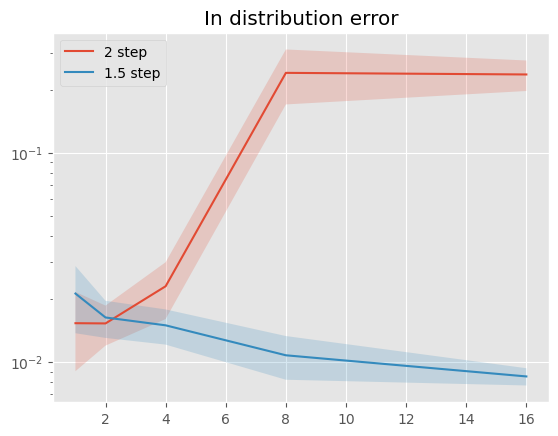

In [87]:
ms = [2**i for i in range(5)]
plt.title('In distribution error')
plt.plot(ms,mean_in_sample_2, label = '2 step')
plt.fill_between(ms,mean_in_sample_2 - sd_in_sample_2,mean_in_sample_2 + sd_in_sample_2,alpha=.2)
plt.yscale('log')
plt.plot(ms,mean_in_sample_1_5, label = '1.5 step')
plt.fill_between(ms,mean_in_sample_1_5 - sd_in_sample_1_5,mean_in_sample_1_5 + sd_in_sample_1_5,alpha=.2)
plt.yscale('log')
plt.legend()
plt.show()

### Out of sample plot

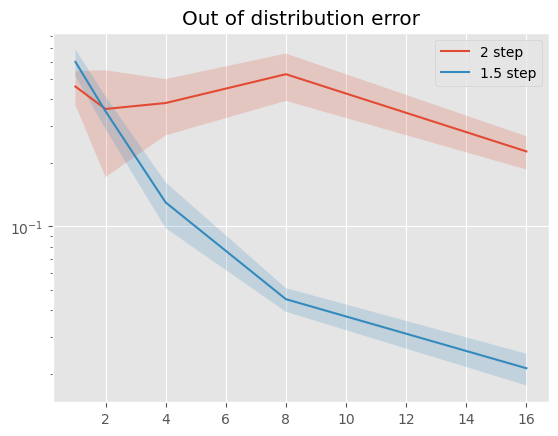

In [88]:
ms = [2**i for i in range(5)]
plt.title('Out of distribution error')
plt.plot(ms,mean_out_sample_2, label = '2 step')
plt.fill_between(ms,mean_out_sample_2 - sd_out_sample_2,mean_out_sample_2 + sd_out_sample_2,alpha=.2)
plt.yscale('log')
plt.plot(ms,mean_out_sample_1_5, label = '1.5 step')
plt.fill_between(ms,mean_out_sample_1_5 - sd_out_sample_1_5,mean_out_sample_1_5 + sd_out_sample_1_5,alpha=.2)
plt.yscale('log')
plt.legend()
plt.show()